# Predicting potential future trends in airline profitability
## Contents
1. [Analytical questions](#Analytical-questions)
2. [Load the data](#Load-the-data)
3. [Exploratory Graphs](#Exploratory-Graphs)
4. [Analytical Questions](#Analytical-Questions)
5. [Q1 - Is fuel price dependent upon the type of aeroplane?](#Q1---Is-fuel-price-dependent-upon-the-type-of-aeroplane?)
6. [Q2 - Is fuel price dependent upon the amount used?](#Q2---Is-fuel-price-dependent-upon-the-amount-used?)
7. [Q3 - How does profit depend upon fuel price?](#Q3---How-does-profit-depend-upon-fuel-price?)
8. [Q4 - How does next year's profit depend upon labour costs?](#Q4---How-does-next-year's-profit-depend-upon-labour-costs?)
9. [Q5 - What could happen to airlines in the future?](#Q5---What-could-happen-to-airlines-in-the-future?)
10. [Q6 - What can we tell from passenger numbers?](#Q6---What-can-we-tell-from-passenger-numbers?)
<!-- Trick from  https://stackoverflow.com/questions/28080066/how-to-reference-a-ipython-notebook-cell-in-markdown-->

## Analytical questions
1. Is fuel price dependent upon the type of aeroplane?
2. Is fuel price dependent upon the amount used?
3. How does profit amounts depend upon fuel price?
4. How does next year's profit depend upon labour costs?
5. What could happen to airlines in the future? Using our models from earlier we will be trying to predict what may happen in the future with:
- Higher priced planes that are more efficient in terms of fuel cost
- Higher priced more efficient planes with a reduced labour cost
- Increased fuel costs due to higher taxes
6. What can we tell from passenger numbers?

In [1]:
# Imports
import pandas as pd
from data.getFlightDataSettings import getFlightDataSettings
import matplotlib.pyplot as plt
%matplotlib inline
# used as a way to allow the matplotlib (& seaborn) plots be interactive without the display function (idea from https://stackoverflow.com/questions/40122837/interactive-matplotlib-using-ipywidgets (weirdly from the question rather than the answer))
import seaborn as sns
import altair as alt

from sklearn.decomposition import PCA
import numpy as np

# Linear Regression imports
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

from IPython.display import display
import xgboost as xgb
from sklearn.svm import SVR 
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller

# My code imports
from data.notebookhelp.getAirlineFromDummies import get_airline_from_dummies
from data.notebookhelp.clustering import clustering as clusterify
from data.notebookhelp.residplots import residual_plots

## Load the data

In [2]:
# Get the data from airlineData.csv
settingsDf = getFlightDataSettings()

df = pd.read_csv('airlineData.csv')
df.drop('Unnamed: 0', inplace=True, axis=1)
df['Airline'] = df['Airline'].astype('category')

for row in settingsDf[settingsDf['DataType'] == 'int'].itertuples():
    df[row.NewColTitle] = df[row.NewColTitle].fillna(0.) # Fill NA ints with 0 so that conversion can take place
    df[row.NewColTitle] = df[row.NewColTitle].astype('int64')
    
# Subset to specific columns
expenseRevenueCols = settingsDf[(settingsDf['Section'] == 'Revenue & Related') | (settingsDf['Section'] == 'Expenses & Related') | (settingsDf['Section'] == 'Aircraft & Related') | (settingsDf['Section'] == 'Traffic, Capacity by Operating Region')].NewColTitle.tolist()
keepCols = ['Airline', 'Year']

# delete settingsDF as no longer used
del settingsDf

for c in expenseRevenueCols:
    keepCols.append(c)
df = df[keepCols]

del c, expenseRevenueCols

InterestingColumns=[
    'Airline',
    'Year',
    'System Total Operating Revenue $billions',
    'System Passenger Revenue billion $',
    'System Total Operating Expenses $ Billions',
    'System Total Operating Expense (ex-Transport Related) $ Million',
    'System Total Operating Expense (ex-Fuel and ex-Transport Related) $ Million',
    'System Total Labor and Related Expenses $ Billions',
    'Total Fuel Expense',
    'Total Gallons of Fuel Millions',
    'Total Price per Gallon of Fuel $US Dollars',
    'System Total Non-Labor Expenses (Total Expenses ex-Fuel, Transport Related, and Labor) $ Million',
    'Transport Related Expenses $Millions',
    'Total Other Outsourcing Expense $Million',
    'System Total Management and Other $Billions',
    'Total Flight Equipment Maintenance Expense $ Million',
    'Total Outsourced Flight Equipment Maintenance Expense $ Million',
    'Total Operating Fleet All Aircraft',
    'Small Narrowbody Operating Fleet (Seat Size 150 and Less,  Single Aisle,  Multi Class Configuration)',
    'Large Narrowbody Operating Fleet (Seat Size 150+, Single Aisle)',
    'Total Widebody Operating Fleet (Dual Aisle)',
    'System Total Enplaned Passengers Thousands',
]

df = df[InterestingColumns]

# Set zeros to na
for idx, col in enumerate(InterestingColumns):
    if idx > 1:
        # from https://stackoverflow.com/questions/49575897/cant-replace-0-to-nan-in-python-using-pandas/49576082
        df[col].replace(0, np.nan, inplace=True)

del idx, col, InterestingColumns

df.head()

Airline  Year  System Total Operating Revenue $billions  \
0     American  1995                                     15.61   
1  Continental  1995                                      4.92   
2        Delta  1995                                     12.56   
3    Northwest  1995                                      8.91   
4       United  1995                                     14.89   

   System Passenger Revenue billion $  \
0                               13.33   
1                                4.35   
2                               11.39   
3                                7.76   
4                               13.03   

   System Total Operating Expenses $ Billions  \
0                                       14.64   
1                                        4.68   
2                                       11.52   
3                                        8.00   
4                                       14.06   

   System Total Operating Expense (ex-Transport Related) $ Million  \
0                                            14564.0                 
1                                             4498.0                 
2                                            11212.0                 
3                                             7896.0                 
4                                            13617.0                 

   System Total Operating Expense (ex-Fuel and ex-Transport Related) $ Million  \
0                                            13085.0                             
1                                             3931.0                             
2                                             9847.0                             
3                                             6869.0                             
4                                            12038.0                             

   System Total Labor and Related Expenses $ Billions  Total Fuel Expense  \
0                                               5.74               1478.0   
1                                               1.32                567.0   
2                                               4.23               1365.0   
3                                               3.03               1027.0   
4                                               5.29               1579.0   

   Total Gallons of Fuel Millions  ...  Transport Related Expenses $Millions  \
0                          2749.0  ...                                  79.0   
1                          1061.0  ...                                 182.0   
2                          2500.0  ...                                 307.0   
3                          1846.0  ...                                 102.0   
4                          2822.0  ...                                 446.0   

   Total Other Outsourcing Expense $Million  \
0                                    1411.0   
1                                     543.0   
2                                    1090.0   
3                                     674.0   
4                                     860.0   

   System Total Management and Other $Billions  \
0                                         0.90   
1                                         0.05   
2                                         0.38   
3                                         0.37   
4                                         0.66   

   Total Flight Equipment Maintenance Expense $ Million  \
0                                             1103.0      
1                                              535.0      
2                                              900.0      
3                                              792.0      
4                                             1478.0      

   Total Outsourced Flight Equipment Maintenance Expense $ Million  \
0                                              204.0                 
1                                              244.0                 
2                                              113.0         

In [3]:
# Work out profit and then the next year's profit
df['profit'] = df['System Total Operating Revenue $billions'] - df['System Total Operating Expenses $ Billions']
def getNextYearProfit(row:pd.Series)->float:
    """Gets the next years profits or NA for when either the data stops entirely or it does for that airline"""
    try:
        ret = df[(df['Year'] == row['Year'] + 1) & (df['Airline'] == row['Airline'])]['profit'].values[0]
    except:
        ret = None
    return ret
df['nextProfit'] = df.apply(lambda row: getNextYearProfit(row),axis=1)
# check that everything weny ok
test = df[['Year','Airline','profit', 'nextProfit']]
test[test['Airline'] == 'American'].head()

Year   Airline  profit  nextProfit
0   1995  American    0.97        1.33
16  1996  American    1.33        1.45
32  1997  American    1.45        1.75
48  1998  American    1.75        1.00
64  1999  American    1.00        1.25

## Exploratory Graphs

System Total Operating Revenue $billions


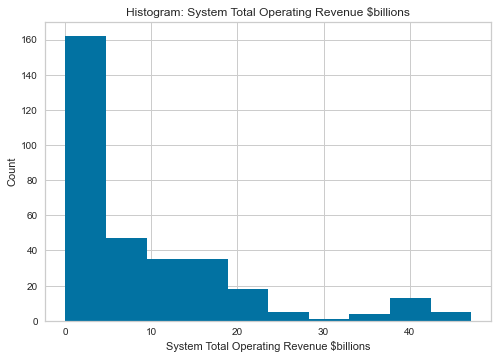

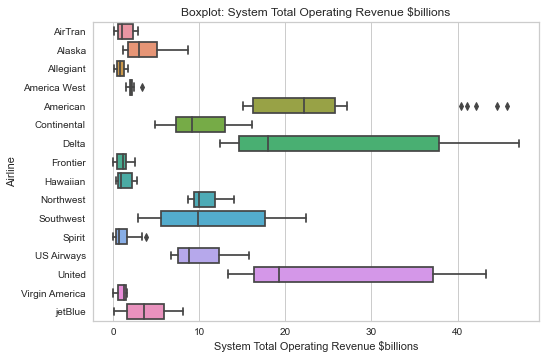

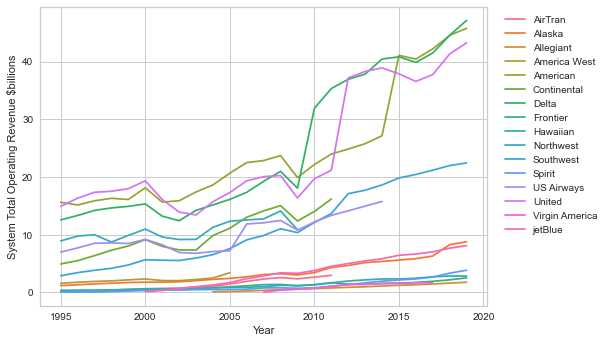

System Passenger Revenue billion $


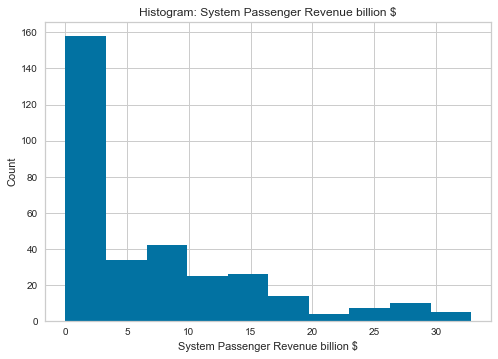

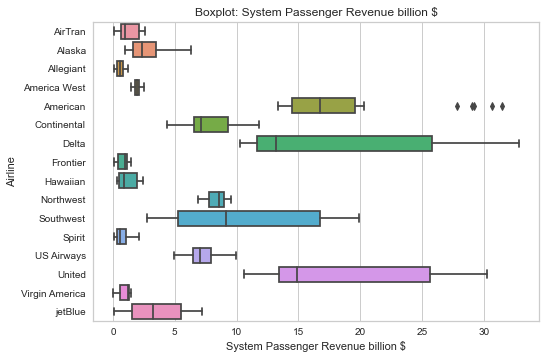

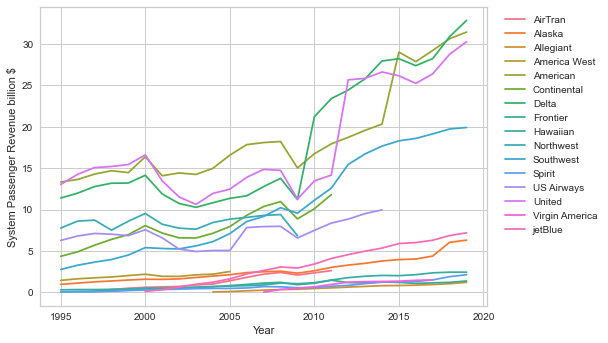

System Total Operating Expenses $ Billions


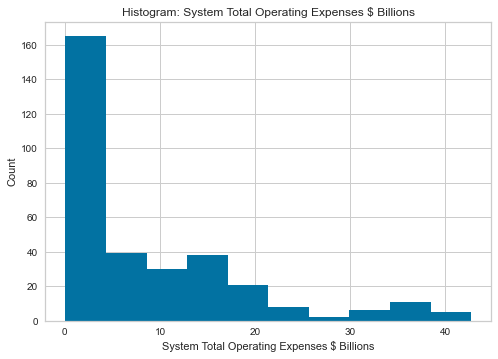

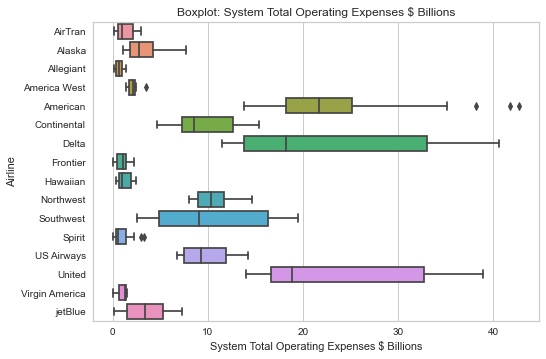

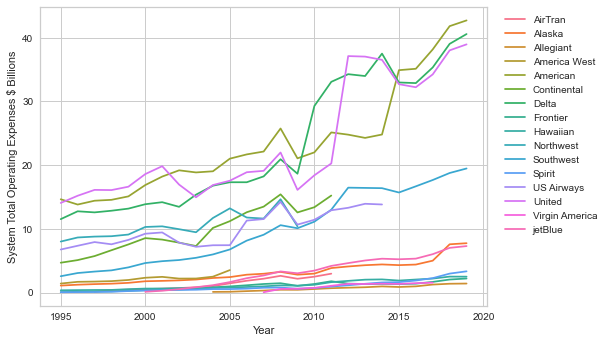

System Total Operating Expense (ex-Transport Related) $ Million


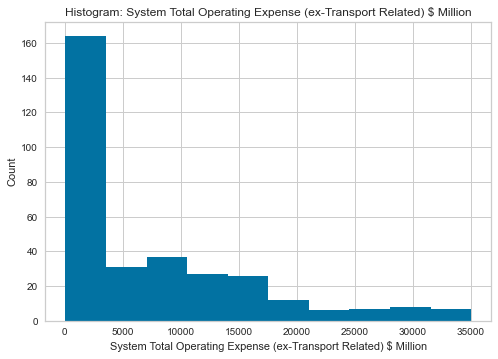

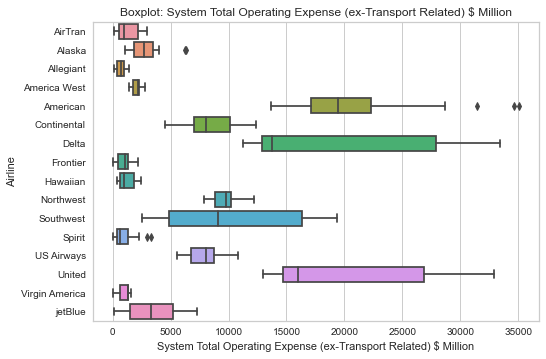

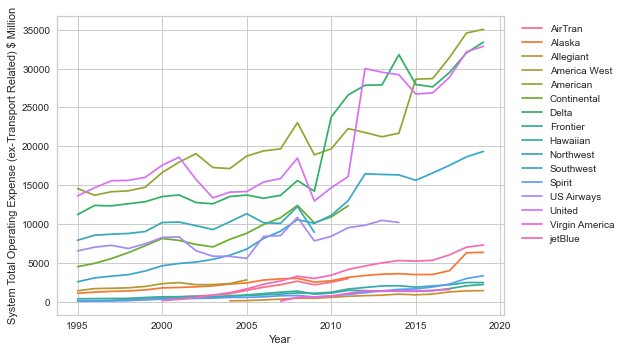

System Total Operating Expense (ex-Fuel and ex-Transport Related) $ Million


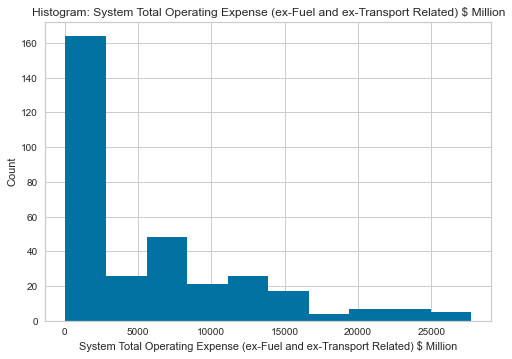

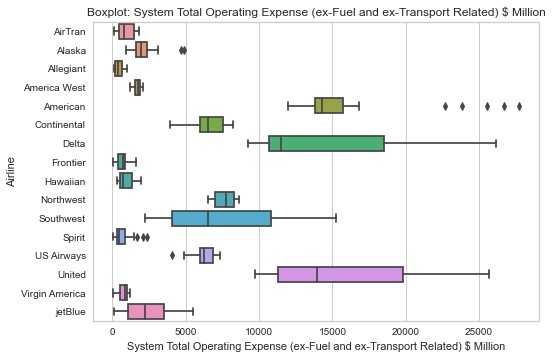

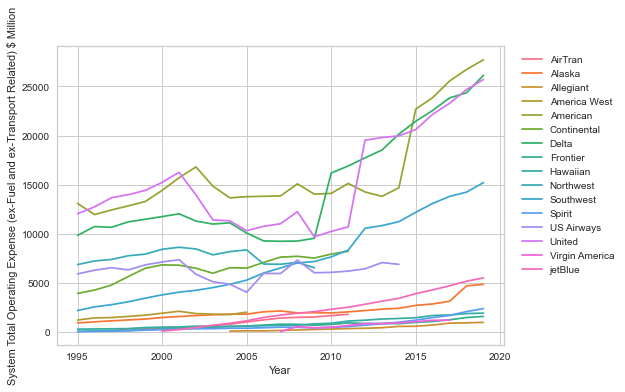

System Total Labor and Related Expenses $ Billions


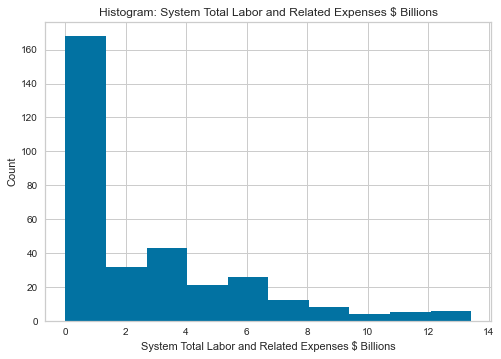

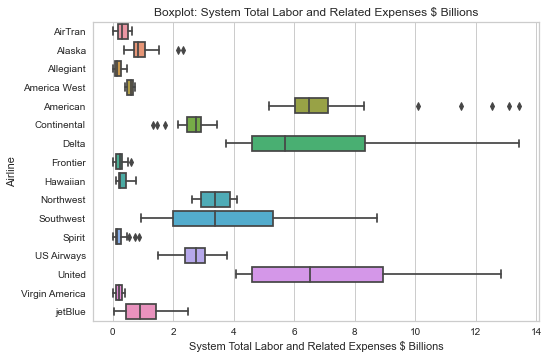

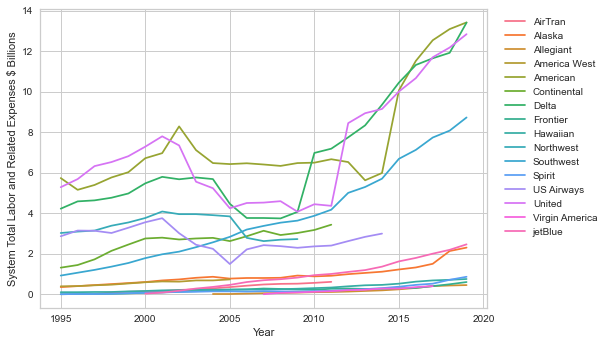

Total Fuel Expense


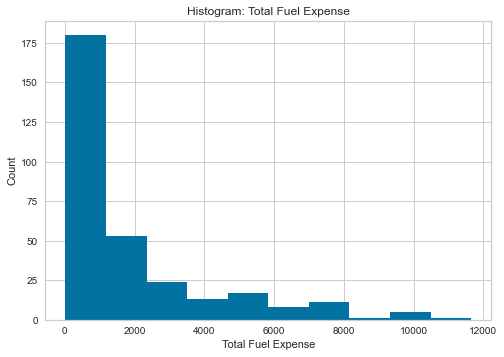

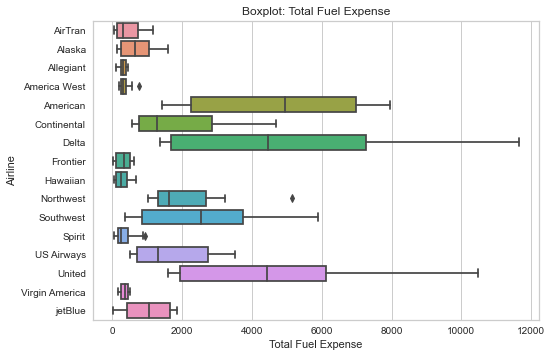

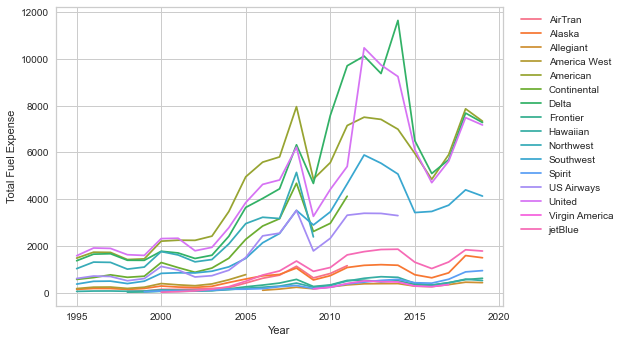

Total Gallons of Fuel Millions


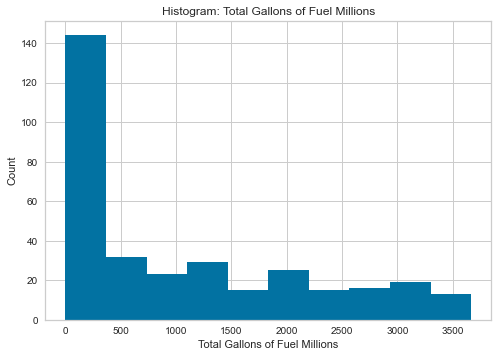

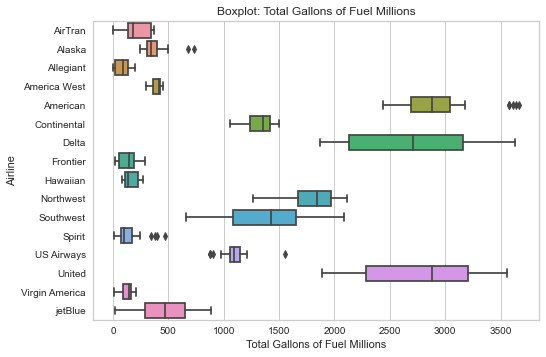

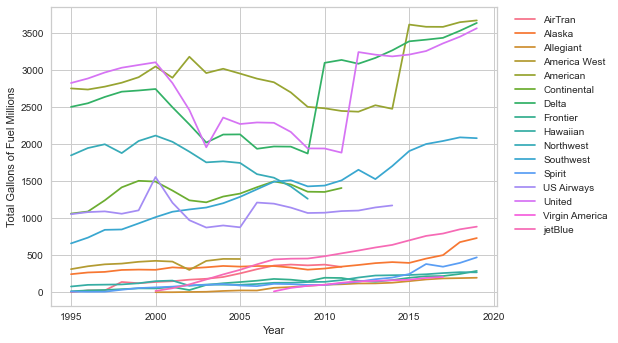

Total Price per Gallon of Fuel $US Dollars


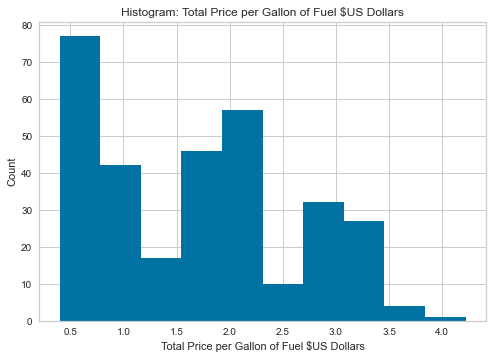

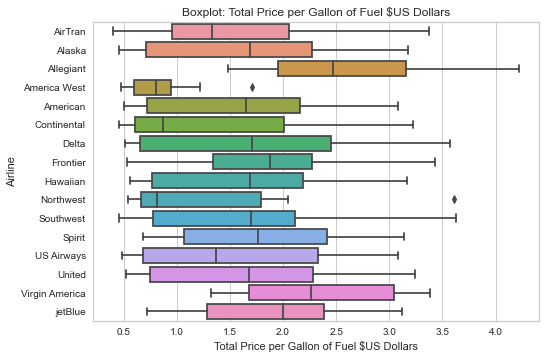

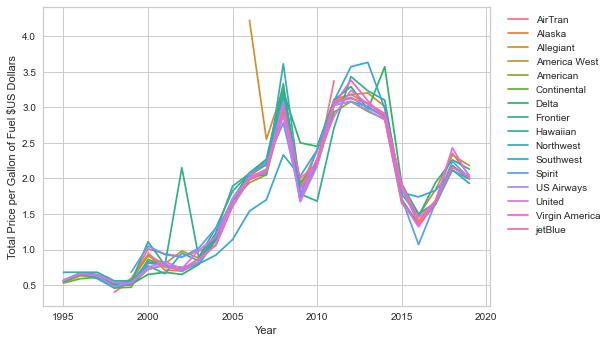

System Total Non-Labor Expenses (Total Expenses ex-Fuel, Transport Related, and Labor) $ Million


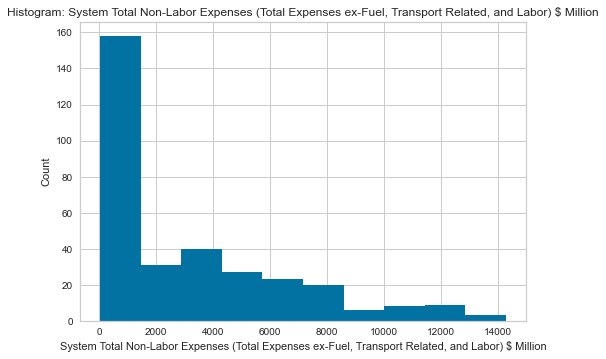

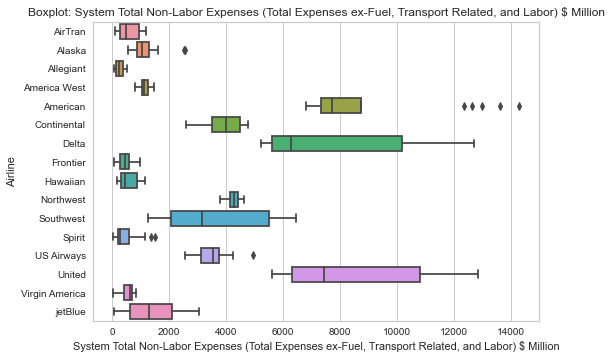

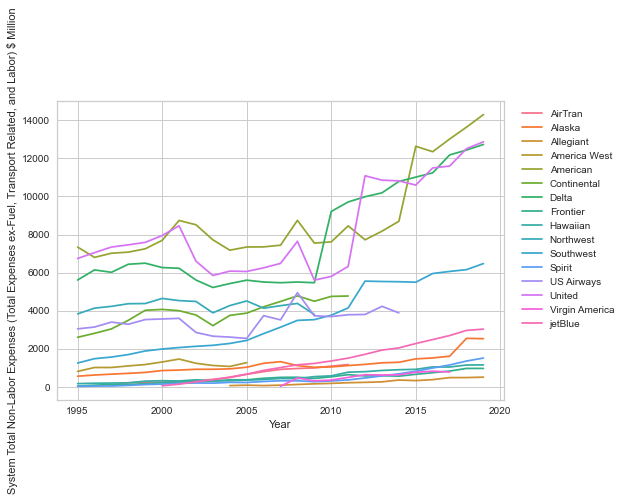

Transport Related Expenses $Millions


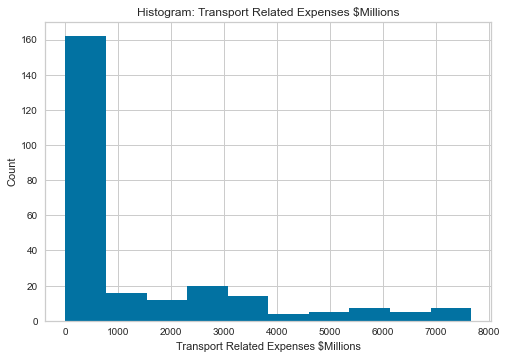

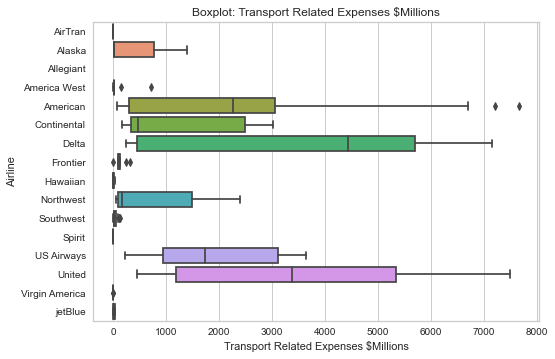

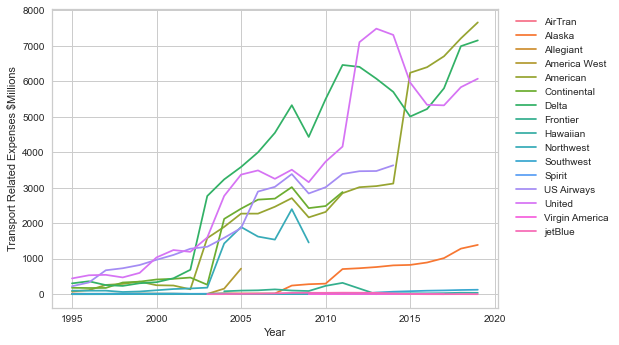

Total Other Outsourcing Expense $Million


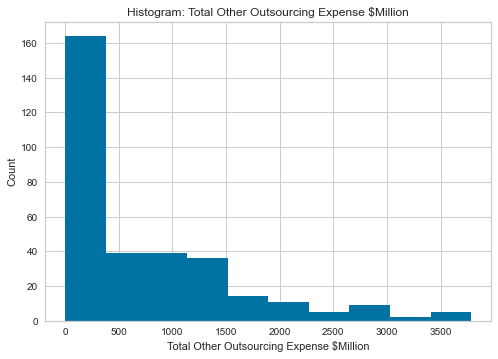

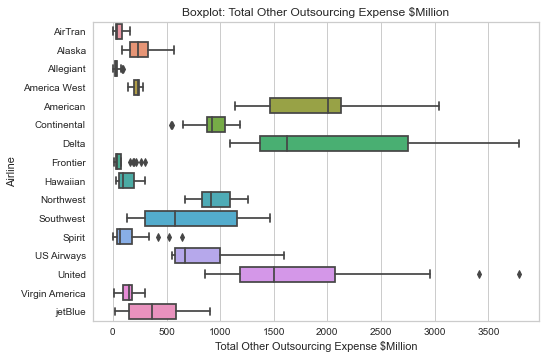

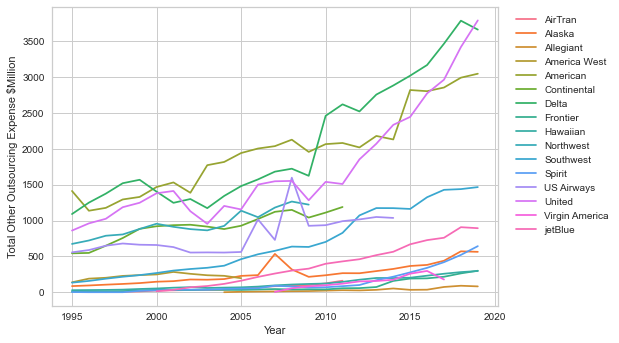

System Total Management and Other $Billions


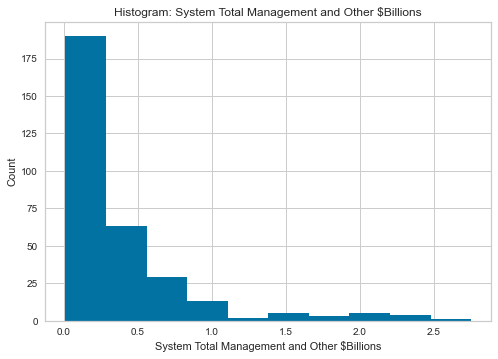

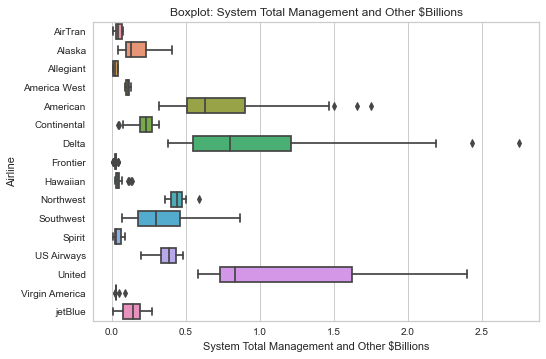

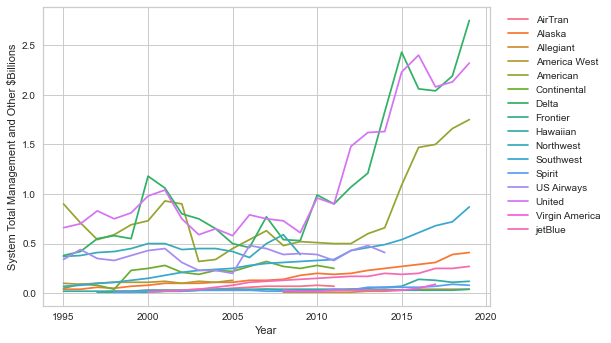

Total Flight Equipment Maintenance Expense $ Million


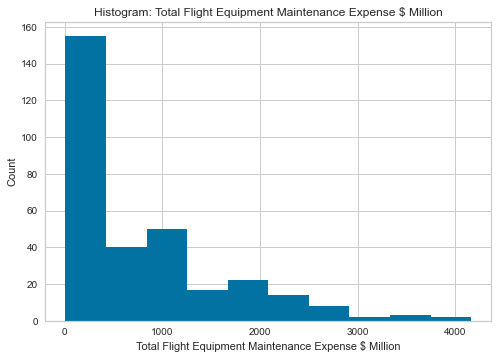

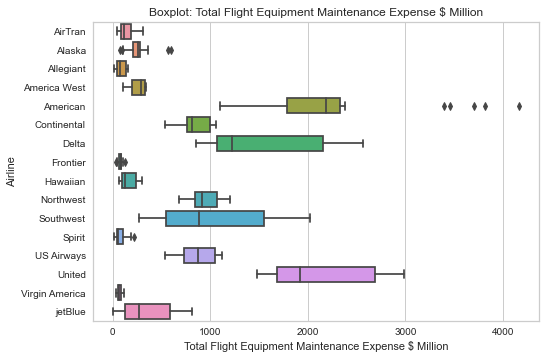

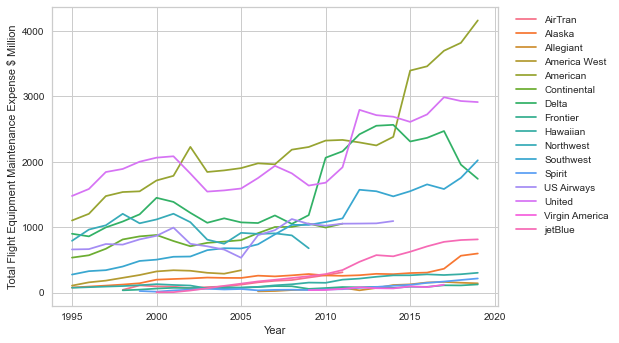

Total Outsourced Flight Equipment Maintenance Expense $ Million


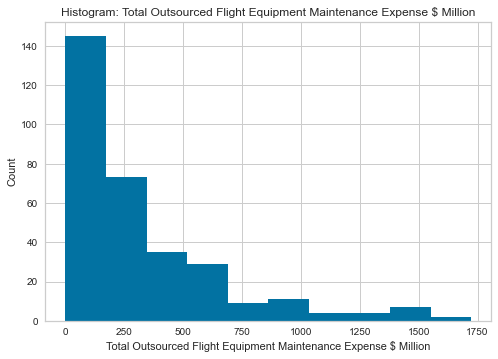

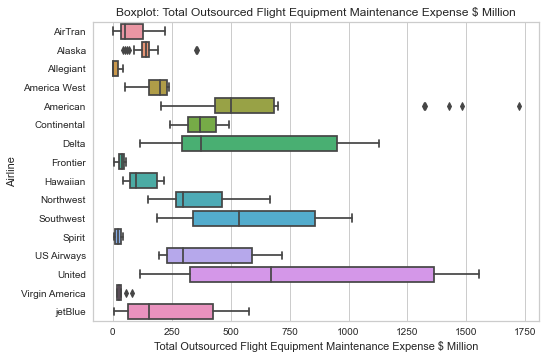

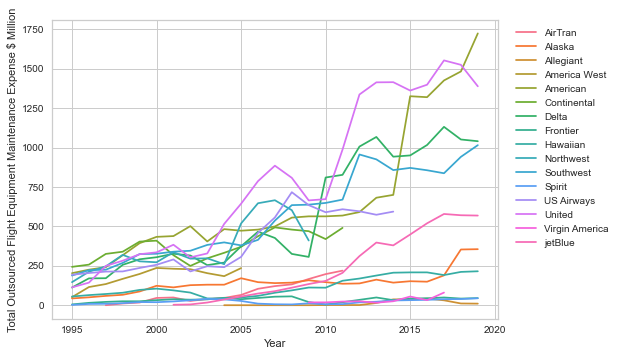

Total Operating Fleet All Aircraft


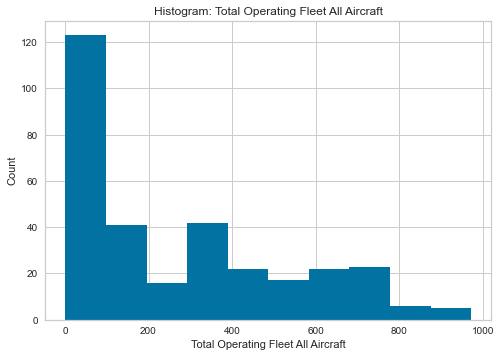

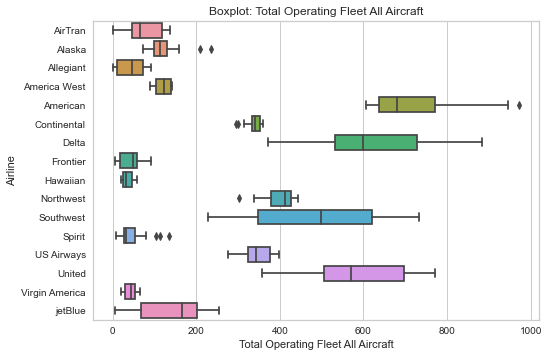

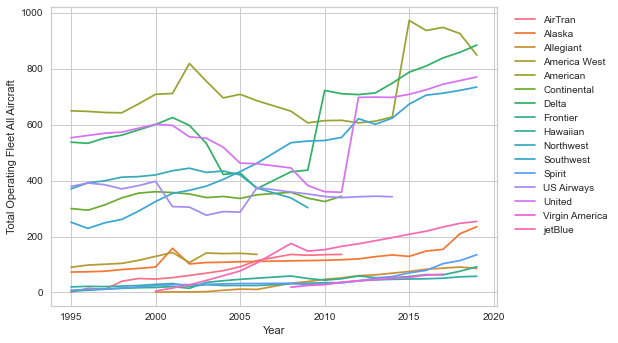

Small Narrowbody Operating Fleet (Seat Size 150 and Less,  Single Aisle,  Multi Class Configuration)


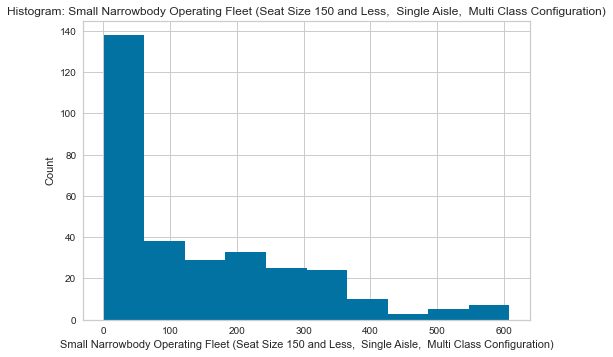

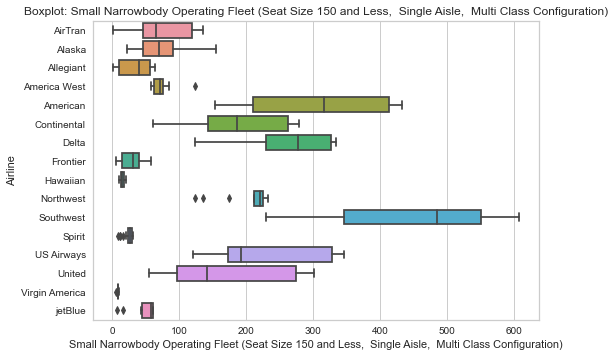

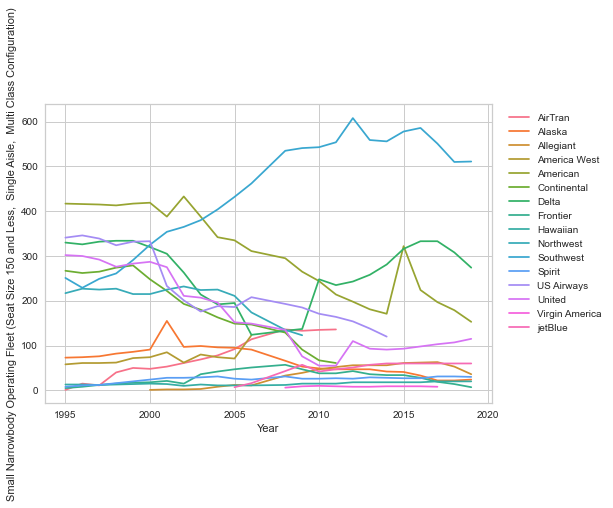

Large Narrowbody Operating Fleet (Seat Size 150+, Single Aisle)


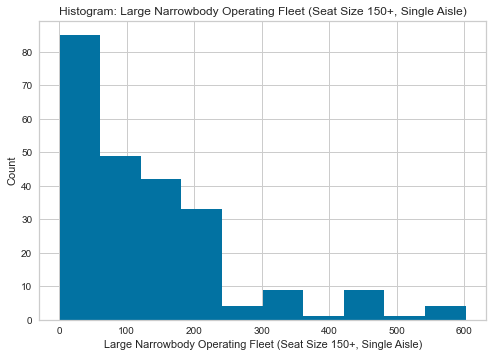

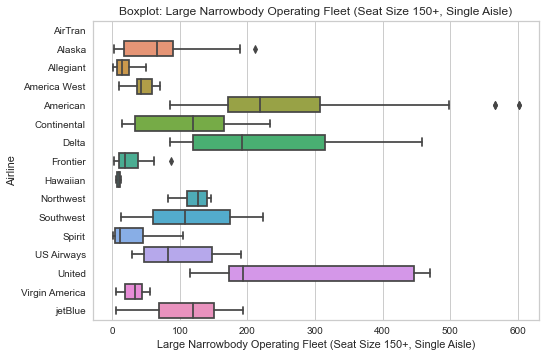

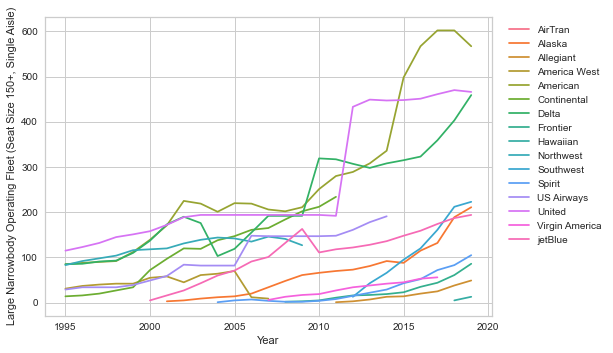

Total Widebody Operating Fleet (Dual Aisle)


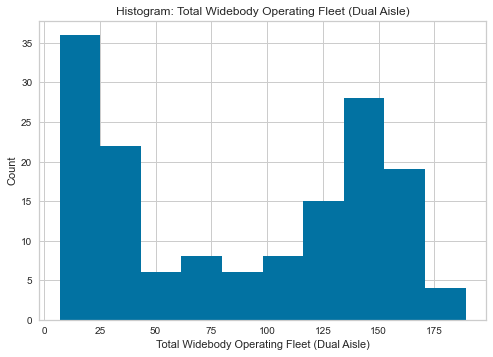

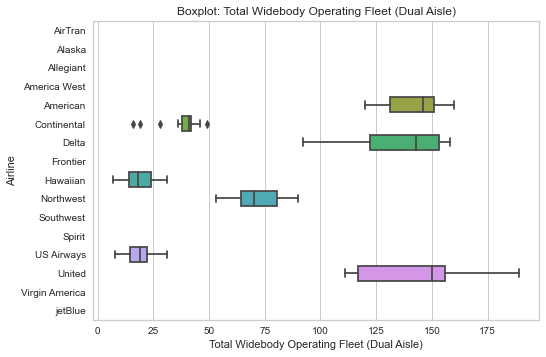

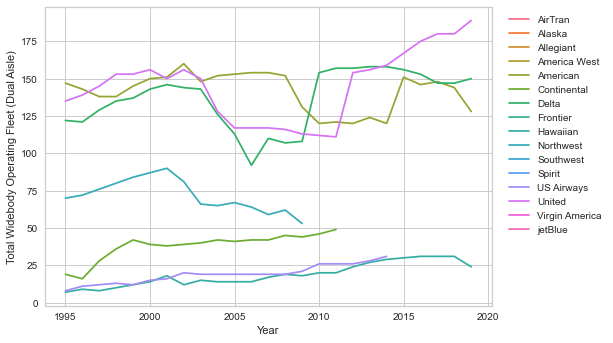

System Total Enplaned Passengers Thousands


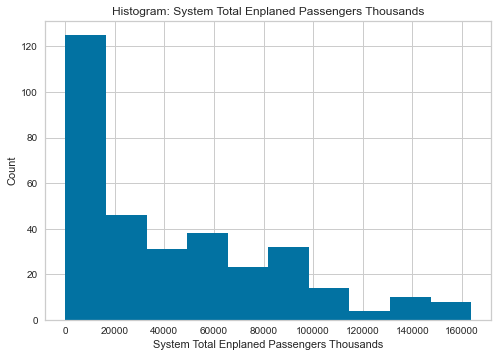

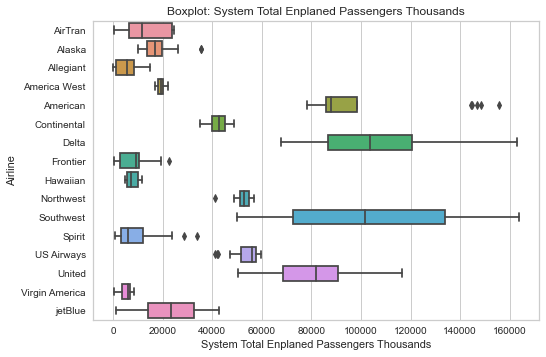

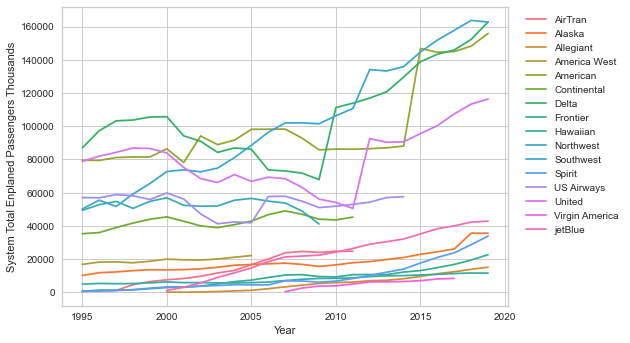

profit


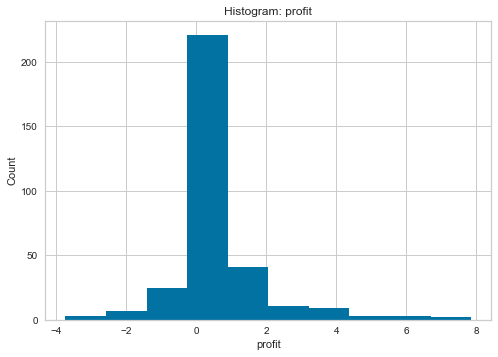

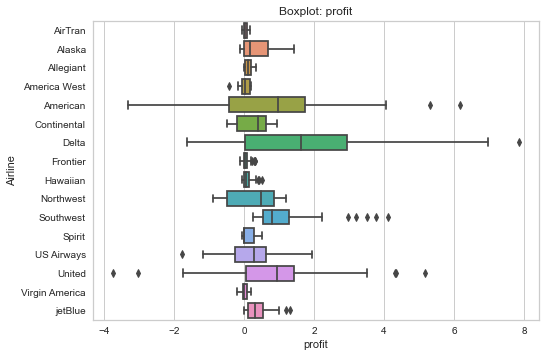

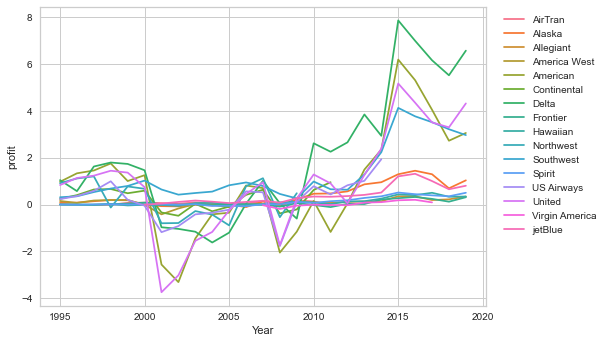

nextProfit


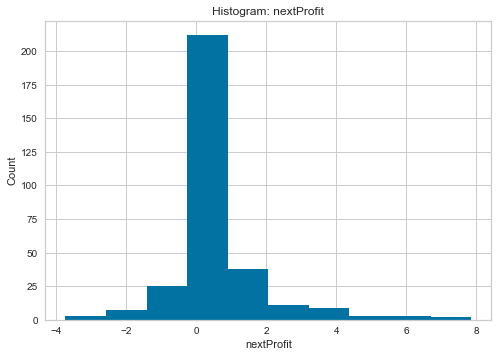

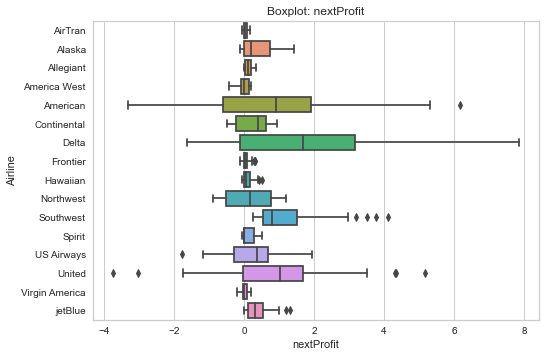

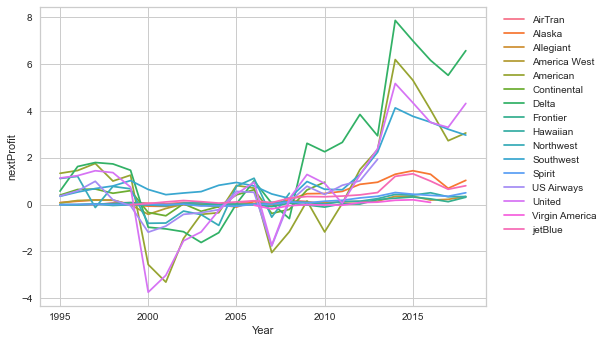

In [4]:
# Originally from lab 4 starter code & my answer to it (more or less), then I started to add seaborn to it and then made it interactive
def summary_stats(columnName:str)->None:
    """Displays Histogram of the selected column's distribution. 
    Along with Boxplot broken down by Airline.
    And linegraph of the data by year, broken down by airline
    
    Params:
    columnName: str - The target column of the dataframe to show"""
    # Histogram
    _ = plt.hist(df[columnName])
    plt.title('Histogram: ' + columnName)
    plt.ylabel('Count')
    plt.xlabel(columnName)
    _ = plt.show()
    
    # Boxplot
    sns.boxplot(data=df, x=columnName, y='Airline')
    plt.title('Boxplot: ' + columnName)
    _ = plt.show()
    
    # Lineplot
    sns.lineplot(data=df, x='Year', y=columnName, hue='Airline')
    plt.legend(bbox_to_anchor=(1.02, 1), loc=2) # from https://www.geeksforgeeks.org/how-to-place-legend-outside-the-plot-with-seaborn-in-python/
    _ = plt.show()

for col in list(filter(lambda x: x not in ['Year', 'Airline'], df.columns)):
    print(col)
    summary_stats(col)

## Analytical Questions
### Q1 - Is fuel price dependent upon the type of aeroplane?

In [5]:
# Using https://altair-viz.github.io/user_guide/customization.html
alt.Chart(df).mark_circle().encode(
    alt.X('Year', scale=alt.Scale(zero=False), axis = alt.Axis(format = 'f')),
    alt.Y("Total Price per Gallon of Fuel $US Dollars", axis=alt.Axis(format = '$', title = 'Total Price per Gallon of Fuel')),
    tooltip=['Total Operating Fleet All Aircraft',
    'Small Narrowbody Operating Fleet (Seat Size 150 and Less,  Single Aisle,  Multi Class Configuration)',
    'Large Narrowbody Operating Fleet (Seat Size 150+, Single Aisle)',
    'Total Widebody Operating Fleet (Dual Aisle)']
) # .interactive()

alt.Chart(...)

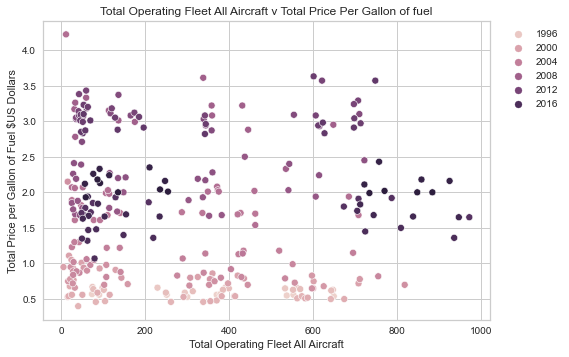

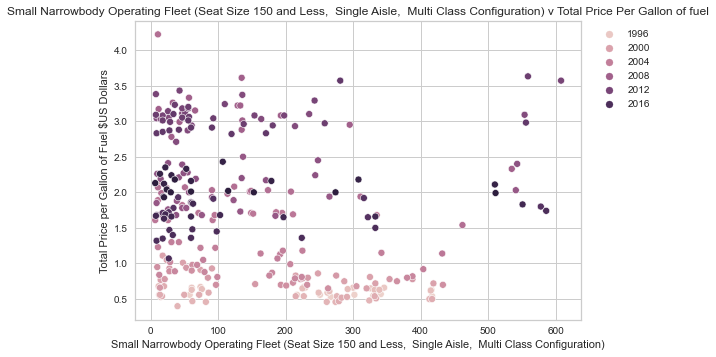

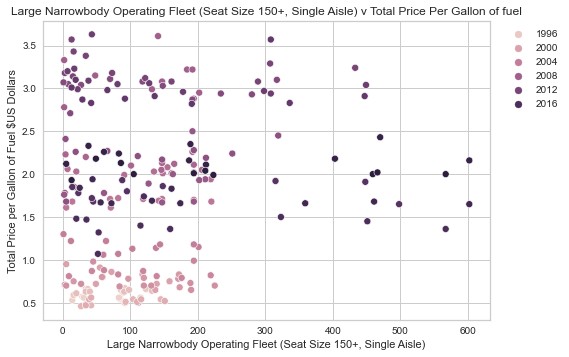

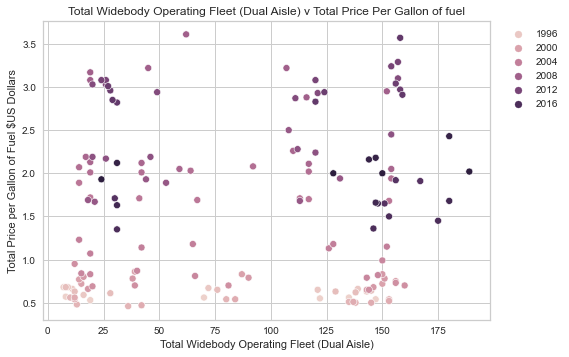

In [6]:
for col in [
        'Total Operating Fleet All Aircraft',
        'Small Narrowbody Operating Fleet (Seat Size 150 and Less,  Single Aisle,  Multi Class Configuration)',
        'Large Narrowbody Operating Fleet (Seat Size 150+, Single Aisle)',
        'Total Widebody Operating Fleet (Dual Aisle)'
    ]:
    sns.scatterplot(data=df, x=col, y='Total Price per Gallon of Fuel $US Dollars', hue='Year')
    plt.legend(bbox_to_anchor=(1.02, 1), loc=2) # code line from https://www.geeksforgeeks.org/how-to-place-legend-outside-the-plot-with-seaborn-in-python/
    plt.title(col + ' v Total Price Per Gallon of fuel')
    plt.show()
del col

Filter to the relevant dimensions. We have 87 rows where the fuel expense hasn't been reported, which we will filter out as we are interested primarily in that column.

In [7]:
# Use PCA to drop the number of dimensions down to 2
X = df[[ # 'Total Operating Fleet All Aircraft', # removed as PC1 was basically this column
    'Small Narrowbody Operating Fleet (Seat Size 150 and Less,  Single Aisle,  Multi Class Configuration)',
    'Large Narrowbody Operating Fleet (Seat Size 150+, Single Aisle)',
    'Total Widebody Operating Fleet (Dual Aisle)', 'Year', 'Total Price per Gallon of Fuel $US Dollars']]
print('NA fuel cost rows:')
display(X[X['Total Price per Gallon of Fuel $US Dollars'].isna() == True])
X = X[X['Total Price per Gallon of Fuel $US Dollars'].isna() == False]
Y = X['Total Price per Gallon of Fuel $US Dollars']
X.drop('Total Price per Gallon of Fuel $US Dollars', axis=1, inplace=True)

# Fill NAs with 0
for col in ['Small Narrowbody Operating Fleet (Seat Size 150 and Less,  Single Aisle,  Multi Class Configuration)',
    'Large Narrowbody Operating Fleet (Seat Size 150+, Single Aisle)',
    'Total Widebody Operating Fleet (Dual Aisle)']:
    X[col].fillna(0, inplace=True)

pca = PCA(n_components=2, random_state=42)
x2 = pca.fit_transform(X)
print('Amount explained by components:\n',pca.explained_variance_ratio_)

# need to unroll x2 so can add to X
# currently each pair of components is at the same level
X['PC1'] = list(map(lambda x: x[0], x2))
X['PC2'] = list(map(lambda x: x[1], x2))

X['Total Operating Fleet All Aircraft'] = df['Total Operating Fleet All Aircraft'].fillna(0)

X['Total Price per Gallon of Fuel $US Dollars'] = Y
print('\nDataframe with Principle components:')
display(X.head())

# Delete PCA object
del pca, col

NA fuel cost rows:


Small Narrowbody Operating Fleet (Seat Size 150 and Less,  Single Aisle,  Multi Class Configuration)  \
8                                                  NaN                                                      
9                                                  1.0                                                      
10                                                 5.0                                                      
11                                                 NaN                                                      
14                                                 8.0                                                      
..                                                 ...                                                      
387                                                NaN                                                      
389                                                NaN                                                      
390                                                NaN                                                      
393                                                NaN                                                      
395                                                NaN                                                      

     Large Narrowbody Operating Fleet (Seat Size 150+, Single Aisle)  \
8                                                  NaN                 
9                                                  NaN                 
10                                                 NaN                 
11                                                 NaN                 
14                                                 NaN                 
..                                                 ...                 
387                                                NaN                 
389                                                NaN                 
390                                                NaN                 
393                                                NaN                 
395                                                NaN                 

     Total Widebody Operating Fleet (Dual Aisle)  Year  \
8                                            NaN  1995   
9                                            NaN  1995   
10                                           NaN  1995   
11                                           NaN  1995   
14                                           NaN  1995   
..                                           ...   ...   
387                                          NaN  2019   
389                                          NaN  2019   
390                                          NaN  2019   
393                                          NaN  2019   
395                                          NaN  2019   

     Total Price per Gallon of Fuel $US Dollars  
8                                           NaN  
9                                           NaN  
10                                          NaN  
11                                          NaN  
14                                          NaN  
..                                          ...  
387                                         NaN  
389                                         NaN  
390                                         NaN  
393                                         NaN  
395                                         NaN  

[87 rows x 5 columns]

Amount explained by components:
 [0.62108428 0.34840631]

Dataframe with Principle components:


Small Narrowbody Operating Fleet (Seat Size 150 and Less,  Single Aisle,  Multi Class Configuration)  \
0                                              417.0                                                      
1                                              267.0                                                      
2                                              330.0                                                      
3                                              217.0                                                      
4                                              302.0                                                      

   Large Narrowbody Operating Fleet (Seat Size 150+, Single Aisle)  \
0                                               85.0                 
1                                               14.0                 
2                                               85.0                 
3                                               83.0                 
4                                              115.0                 

   Total Widebody Operating Fleet (Dual Aisle)  Year         PC1         PC2  \
0                                        147.0  1995  245.918003 -138.426881   
1                                         19.0  1995   52.940909 -141.860826   
2                                        122.0  1995  167.575532  -95.876653   
3                                         70.0  1995   59.671330  -46.905193   
4                                        135.0  1995  162.919723  -53.307512   

   Total Operating Fleet All Aircraft  \
0                               649.0   
1                               300.0   
2                               537.0   
3                               370.0   
4                               553.0   

   Total Price per Gallon of Fuel $US Dollars  
0                                        0.54  
1                                        0.53  
2                                        0.55  
3                                        0.56  
4                                        0.56

In [8]:
# Plot PCA1 against price, as PC1 explains 62% of the variation
alt.Chart(X).mark_circle().encode(
    alt.X('PC1', scale=alt.Scale(zero=False), axis=alt.Axis(format='f')),
    alt.Y('Total Price per Gallon of Fuel $US Dollars', axis=alt.Axis(format='$', title='Total Price per Gallon of Fuel')),
    tooltip=['Total Operating Fleet All Aircraft',
    'Small Narrowbody Operating Fleet (Seat Size 150 and Less,  Single Aisle,  Multi Class Configuration)',
    'Large Narrowbody Operating Fleet (Seat Size 150+, Single Aisle)',
    'Total Widebody Operating Fleet (Dual Aisle)', 'Year'],
    color=alt.Color('Total Operating Fleet All Aircraft', scale=alt.Scale(scheme='blueorange')) # from https://stackoverflow.com/questions/55379035/set-a-diverging-color-scheme-to-center-on-zero-in-altair
) # .interactive()

alt.Chart(...)

PC1 does seem to have distributed depending upon the total number of aircraft rather than the type. However there was no dependany upon the year the data was from.

alt.Chart(...)

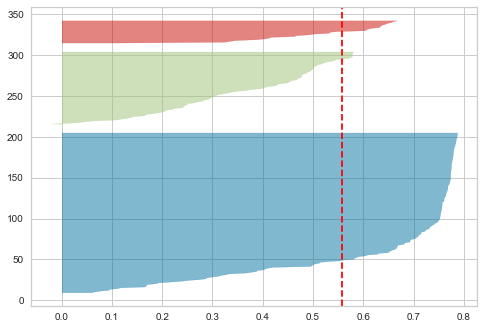

Silhouette Score: 0.5580453970109827


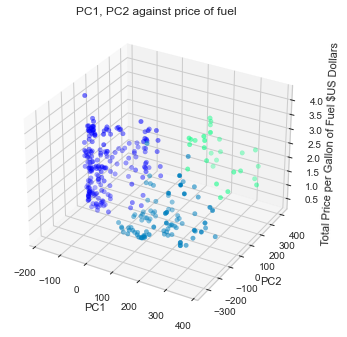

In [9]:
#@widgets.interact(num_clusters=widgets.IntSlider(min=2, max=15, step=1, value=3))
def clust(num_clusters:int)->None:
    """Show the clusters on the PC1 versus Price of fuel"""
    # I have moved the actual clustering to its own script as it was getting a bit busy
    c = clusterify(num_clusters, False, X, ['PC1', 'PC2', 'Total Price per Gallon of Fuel $US Dollars'])
    display(alt.Chart(X, title='PC1 verus price of fuel (PC2 is used in the clusters)').mark_circle().encode(
            alt.X('PC1', scale=alt.Scale(zero=False), axis=alt.Axis(format='f')),
            alt.Y('Total Price per Gallon of Fuel $US Dollars', axis=alt.Axis(format='$', title='Total Price per Gallon of Fuel')),
            tooltip=['Total Operating Fleet All Aircraft',
            'Small Narrowbody Operating Fleet (Seat Size 150 and Less,  Single Aisle,  Multi Class Configuration)',
            'Large Narrowbody Operating Fleet (Seat Size 150+, Single Aisle)',
            'Total Widebody Operating Fleet (Dual Aisle)', 'Year', 'PC2'],
            # Get Altair colour schemes from https://vega.github.io/vega/docs/schemes/
            color=alt.Color('cluster:Q', scale=alt.Scale(scheme='category20')) # from https://stackoverflow.com/questions/55379035/set-a-diverging-color-scheme-to-center-on-zero-in-altair
        ))#.interactive())
    plt.show()
    print('Silhouette Score:', c)
    
    # Using https://matplotlib.org/2.0.2/mpl_toolkits/mplot3d/tutorial.html
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(
        X['PC1'],
        X['PC2'],
        X['Total Price per Gallon of Fuel $US Dollars'],
        c=X['cluster'], # From https://stackoverflow.com/questions/8202605/matplotlib-scatterplot-color-as-a-function-of-a-third-variable
        cmap='winter' # from https://www.analyticsvidhya.com/blog/2020/09/colormaps-matplotlib/
    )
    ax.set_zlabel('Total Price per Gallon of Fuel $US Dollars')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    plt.title('PC1, PC2 against price of fuel')
    plt.show()
clust(3) # best value

The best number of clusters looks like it is 3, when PC1, PC2 and price per gallon are used.

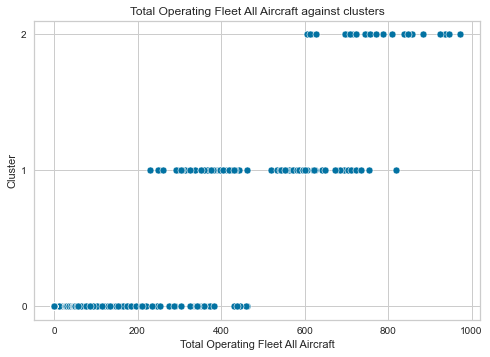

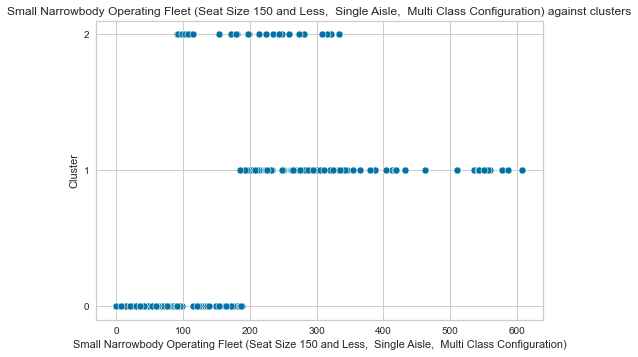

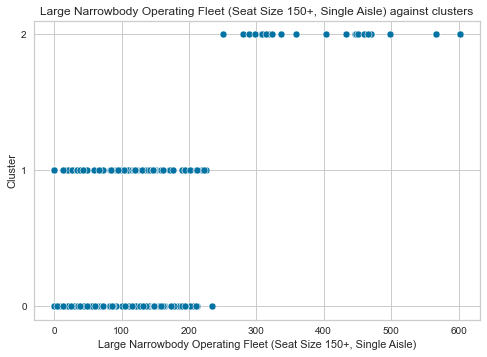

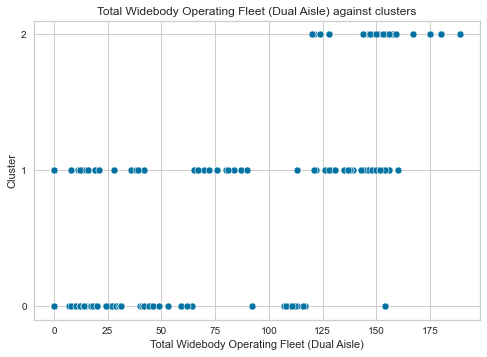

In [10]:
def showClusterForPlanes()->None:
    """Graph to show how the column slots into the clusters"""
    clusters = 3
    clusterify(clusters, True, X, ['PC1', 'PC2', 'Total Price per Gallon of Fuel $US Dollars'])
    for col in ['Total Operating Fleet All Aircraft',
        'Small Narrowbody Operating Fleet (Seat Size 150 and Less,  Single Aisle,  Multi Class Configuration)',
        'Large Narrowbody Operating Fleet (Seat Size 150+, Single Aisle)',
        'Total Widebody Operating Fleet (Dual Aisle)']:
        sns.scatterplot(y='cluster', x=col, data=X)
        # Make sure there is a tick for every cluster
        plt.yticks(np.arange(0, clusters, 1))
        plt.ylabel('Cluster')
        plt.title(col + ' against clusters')
        plt.show()
showClusterForPlanes()

It appears from the clustering that the clusters are more dependent upon the total number of all of the planes than any particular type of plane. There is no significant relationship between the type of plane and which cluster it ends up in.

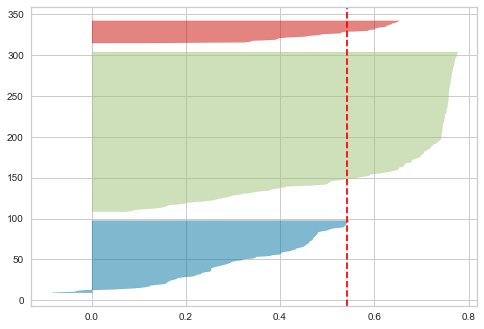

Score: 0.5426202706391324


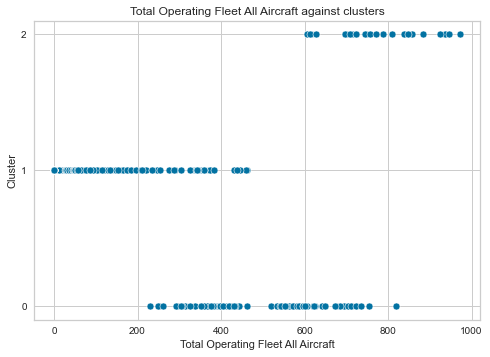

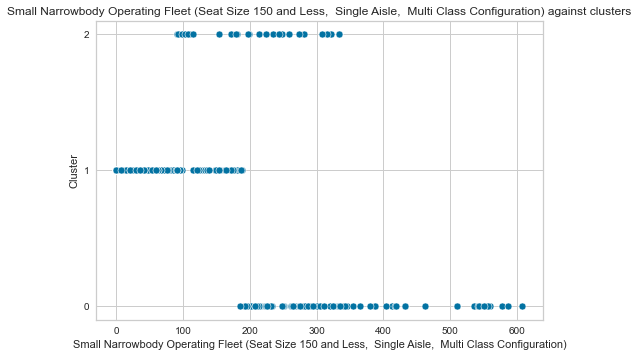

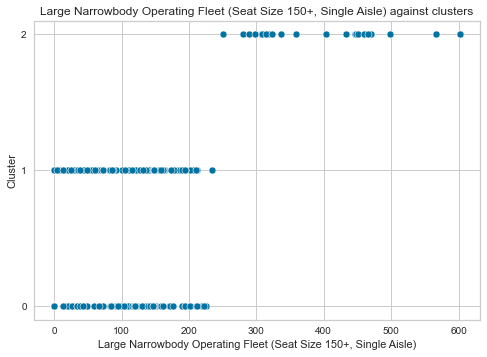

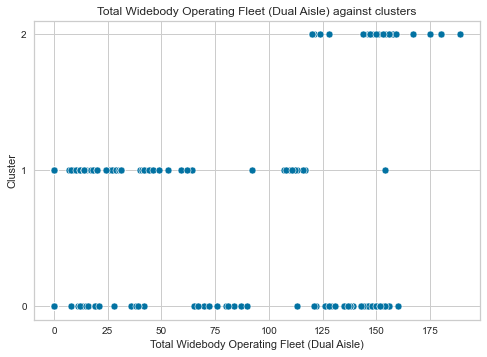

In [11]:
def ClusterForPlanesNoPCA(num_clusters):
    """Rerun of above but without PCA first, roughly the same conclusion that the absolute number of planes is more important than any particular type"""
    cols = ['Small Narrowbody Operating Fleet (Seat Size 150 and Less,  Single Aisle,  Multi Class Configuration)',
       'Large Narrowbody Operating Fleet (Seat Size 150+, Single Aisle)',
       'Total Widebody Operating Fleet (Dual Aisle)', 'Year',
       'Total Price per Gallon of Fuel $US Dollars']
    # run the clustering and yellowjacket package
    scr = clusterify(num_clusters, False, X, cols)
    plt.show()
    print("Score:", scr)

    # Show individual scatter plots to see what is in the clusters
    for col in ['Total Operating Fleet All Aircraft',
        'Small Narrowbody Operating Fleet (Seat Size 150 and Less,  Single Aisle,  Multi Class Configuration)',
        'Large Narrowbody Operating Fleet (Seat Size 150+, Single Aisle)',
        'Total Widebody Operating Fleet (Dual Aisle)']:
        sns.scatterplot(y='cluster', x=col, data=X)
        # make sure there is a point for every cluster
        plt.yticks(np.arange(0, num_clusters, 1))
        plt.ylabel('Cluster')
        plt.title(col + ' against clusters')
        plt.show()
    
ClusterForPlanesNoPCA(3) # best (8 is also good)

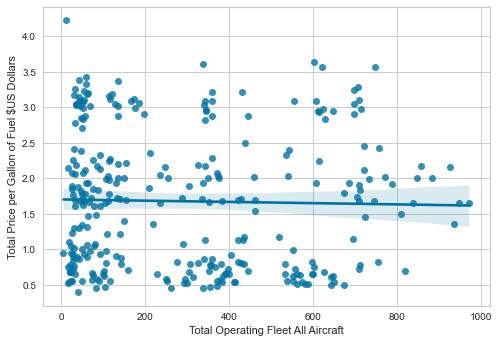

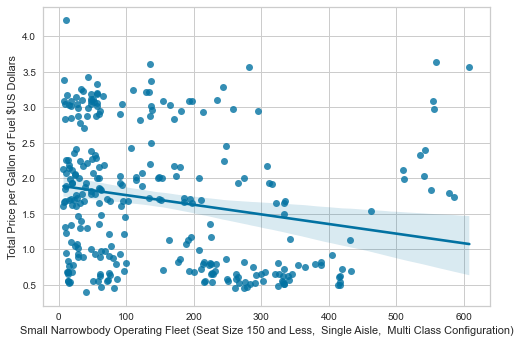

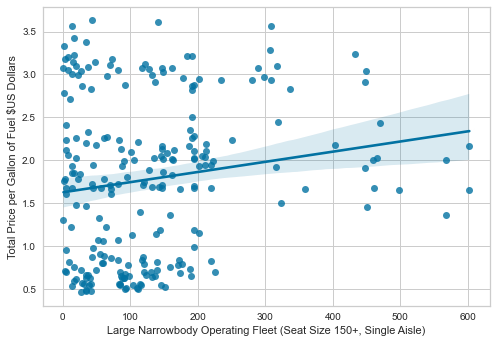

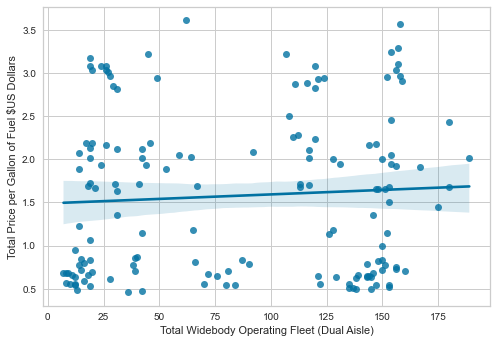

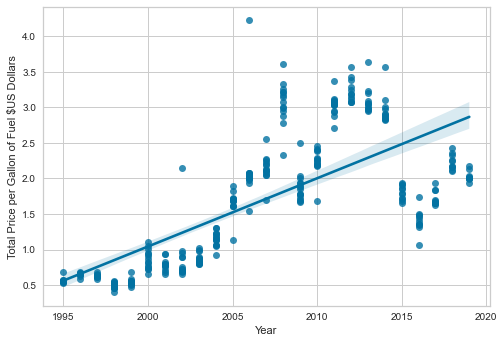

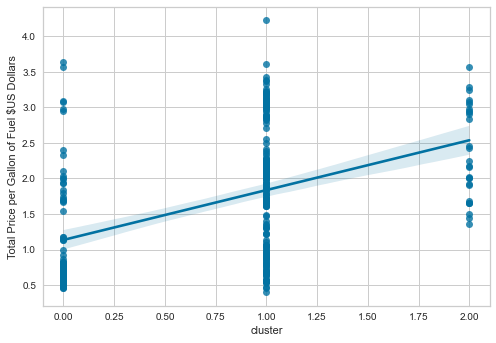

Small Narrowbody Operating Fleet (Seat Size 150 and Less,  Single Aisle,  Multi Class Configuration)  \
Small Narrowbody Operating Fleet (Seat Size 150...                                           1.000000                                                      
Large Narrowbody Operating Fleet (Seat Size 150...                                           0.229424                                                      
Total Widebody Operating Fleet (Dual Aisle)                                                  0.393384                                                      
Year                                                                                        -0.185929                                                      
PC1                                                                                          0.891689                                                      
PC2                                                                                         -0.452152                                                      
Total Operating Fleet All Aircraft                                                           0.779641                                                      
Total Price per Gallon of Fuel $US Dollars                                                  -0.206222                                                      
cluster                                                                                     -0.560818                                                      

                                                    Large Narrowbody Operating Fleet (Seat Size 150+, Single Aisle)  \
Small Narrowbody Operating Fleet (Seat Size 150...                                           0.229424                 
Large Narrowbody Operating Fleet (Seat Size 150...                                           1.000000                 
Total Widebody Operating Fleet (Dual Aisle)                                                  0.756834                 
Year                                                                                         0.388773                 
PC1                                                                                          0.641092                 
PC2                                                                                          0.761404                 
Total Operating Fleet All Aircraft                                                           0.760745                 
Total Price per Gallon of Fuel $US Dollars                                                   0.194689                 
cluster                                                                                      0.396100                 

                                                    Total Widebody Operating Fleet (Dual Aisle)  \
Small Narrowbody Operating Fleet (Seat Size 150...                                     0.393384   
Large Narrowbody Operating Fleet (Seat Size 150...                                     0.756834   
Total Widebody Operating Fleet (Dual Aisle)                                            1.000000   
Year                                                                                  -0.019719   
PC1                                                                                    0.695510   
PC2                                                                                    0.476381   
Total Operating Fleet All Aircraft                                                     0.790911   
Total Price per Gallon of Fuel $US Dollars                                            -0.062056   
cluster                                                                                0.049966   

                                                        Year           PC1  \
Small Narrowbody Operating Fleet (Seat Size 150... -0.185929  8.916890e-01   
Large Narrowbody Operating Fleet (Seat Size 150...  0.388773  6.410924e-01   
Total Widebody Operating Fleet (Dual Aisle)        -0.019719  6.955104e-01 

In [12]:
def showRegPlots(filter_zeros:bool)->None:
    """This runs the regression plots

    Params:
    filter_zeros: bool = remove zero entries for that column

    Returns
    None"""
    for col in ['Total Operating Fleet All Aircraft',
        'Small Narrowbody Operating Fleet (Seat Size 150 and Less,  Single Aisle,  Multi Class Configuration)',
        'Large Narrowbody Operating Fleet (Seat Size 150+, Single Aisle)',
        'Total Widebody Operating Fleet (Dual Aisle)','Year', 'cluster']:
        if filter_zeros and col != 'cluster':
            sns.regplot(data=X[X[col] != 0], x=col, y='Total Price per Gallon of Fuel $US Dollars')
        else:
            sns.regplot(data=X, x=col, y='Total Price per Gallon of Fuel $US Dollars')

        plt.show()
showRegPlots(True)
display(X.corr())

The fuel price appears to increase with the number of widebody and large narrowbody planes in the airline fleet, and decreases as the number of small narrowbody planes increases. It seems to stay flat with the total number of planes. However the effect of the year is far more pronounced than any effect of plane type. From the last plot we can see that apart from a couple of anomalies all of the year's prices are very tightly clustered, meaning that fuel prices are more susceptible to other events going on in that year than any particular breakdown by type of plane. From the correlations we can see that the greatest contributor to price variation is the year.
As we can see from the last graph, although cluster has the second highest correlation to price (at 0.44 it wasn't exactly strong) it has so much noise that there doesn't seem to be a relationship.

For Question 1 - Is fuel price dependent upon the type of aeroplane? We are concluding no.

### Q2 - Is fuel price dependent upon the amount used?

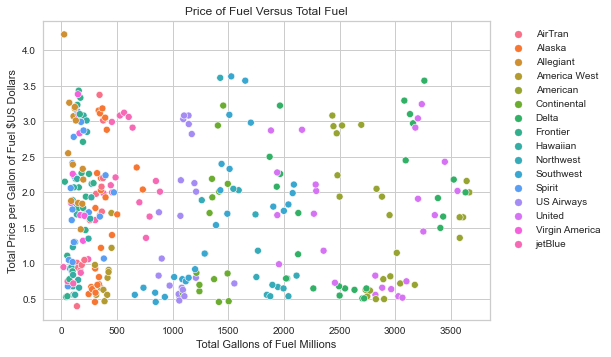

Total Price per Gallon of Fuel $US Dollars  \
Total Price per Gallon of Fuel $US Dollars                                    1.000000   
Total Gallons of Fuel Millions                                               -0.060309   
Year                                                                          0.710172   

                                            Total Gallons of Fuel Millions  \
Total Price per Gallon of Fuel $US Dollars                       -0.060309   
Total Gallons of Fuel Millions                                    1.000000   
Year                                                              0.026075   

                                                Year  
Total Price per Gallon of Fuel $US Dollars  0.710172  
Total Gallons of Fuel Millions              0.026075  
Year                                        1.000000

Corr
Airline                 
AirTran         0.876336
Northwest      -0.795380
Allegiant      -0.670645
Southwest       0.668406
jetBlue         0.560400
America West    0.495718
Frontier        0.478230
Hawaiian        0.452862
Continental     0.435893
Alaska          0.359749
Virgin America -0.291288
American       -0.275974
Delta           0.237109
Spirit          0.114572
US Airways      0.100850
United         -0.032820

In [13]:
# Get the list of airlines and sort them into order
lstAirlines = sorted(list(set(df['Airline'].tolist())))

def getReducedDfForFuelPrice()->pd.DataFrame:
    """This is to get the reduced dataframe for Q2. Picking the three columns, filling NAs and then wiping zeros"""
    # filter the data frame
    tmp = df[['Total Price per Gallon of Fuel $US Dollars','Total Gallons of Fuel Millions', 'Airline','Year']].copy()

    # Fill the NAs
    tmp['Total Price per Gallon of Fuel $US Dollars'].fillna(0, inplace=True)
    tmp['Total Gallons of Fuel Millions'].fillna(0, inplace=True)

    # Drop zeros & previous NAs
    tmp = tmp[(tmp['Total Price per Gallon of Fuel $US Dollars'] != 0) & (tmp['Total Gallons of Fuel Millions'] != 0)]
    return tmp

def fuelExpensePerMGallon()->None:
    """This is to plot the amount of fuel used against the price of fuel"""
    tmp = getReducedDfForFuelPrice()
    sns.scatterplot(data=tmp, y='Total Price per Gallon of Fuel $US Dollars', x='Total Gallons of Fuel Millions', hue='Airline')
    plt.legend(bbox_to_anchor=(1.02, 1), loc=2) # from https://www.geeksforgeeks.org/how-to-place-legend-outside-the-plot-with-seaborn-in-python/
    plt.title('Price of Fuel Versus Total Fuel')
    plt.show()
    
    # Get the correlations for all
    display(tmp.corr())
    
    # Get correlation per airline    
    corrs = [tmp[tmp['Airline'] == x].corr().iloc[1,0] for x in lstAirlines]
    
    t2 = pd.DataFrame.from_dict({'Airline':lstAirlines, 'Corr': corrs})
    # Get the absolute values for sorting
    t2['abs'] = t2['Corr'].apply(abs)
    t2.sort_values('abs', inplace=True, ascending=False)
    
    # Set the index to make it look nicer
    t2.set_index('Airline', inplace=True)
    
    # drop the now redundent abs column
    t2.drop('abs', inplace=True, axis=1)
    display(t2)
    
fuelExpensePerMGallon()

AirTran
Correlation: 0.8763356239881988


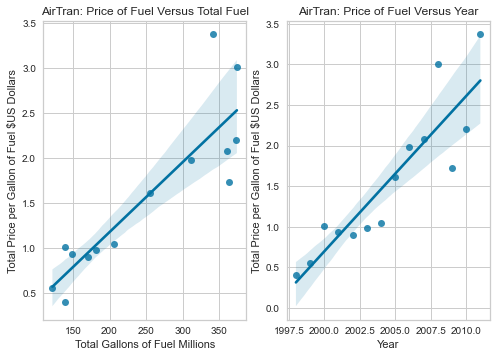

Alaska
Correlation: 0.3597486206755085


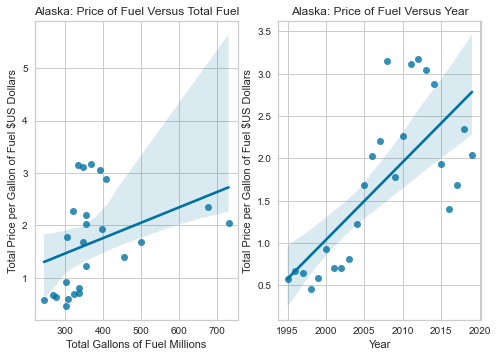

Allegiant
Correlation: -0.6706448850268364


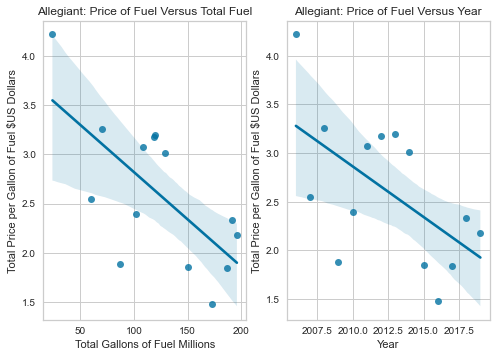

America West
Correlation: 0.49571789700844726


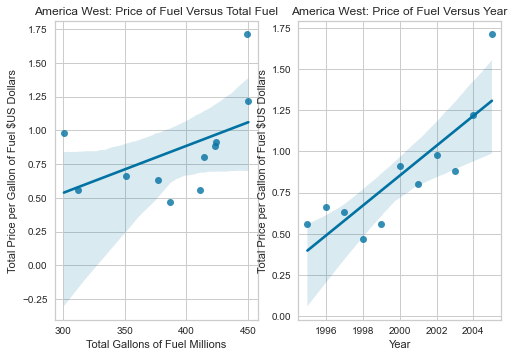

American
Correlation: -0.2759740247094071


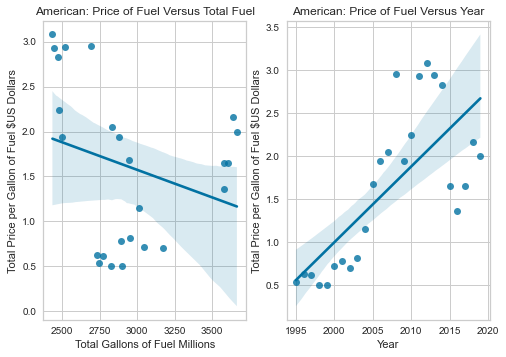

Continental
Correlation: 0.4358932268518511


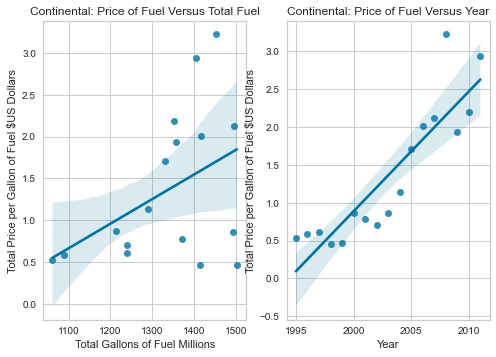

Delta
Correlation: 0.23710944672284764


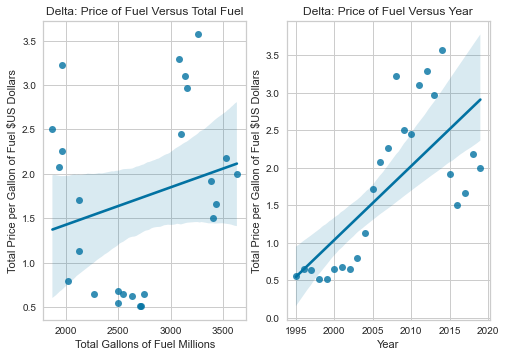

Frontier
Correlation: 0.4782295739208223


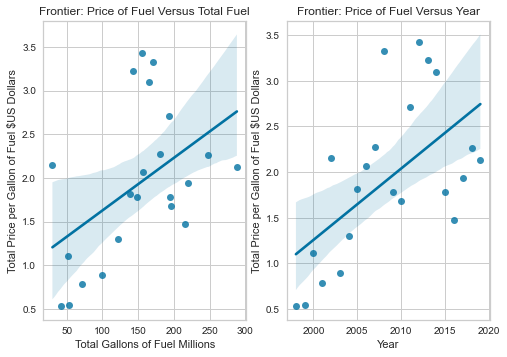

Hawaiian
Correlation: 0.45286245318654983


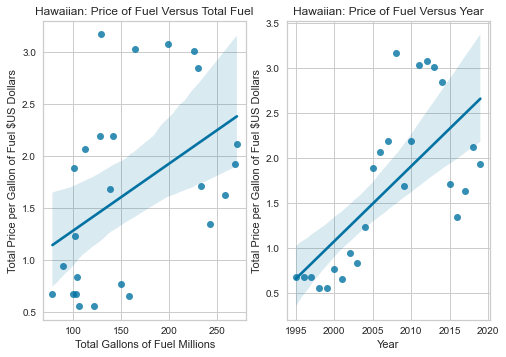

Northwest
Correlation: -0.7953800123442774


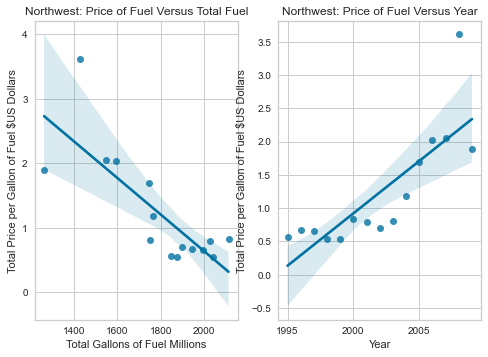

Southwest
Correlation: 0.6684057305516431


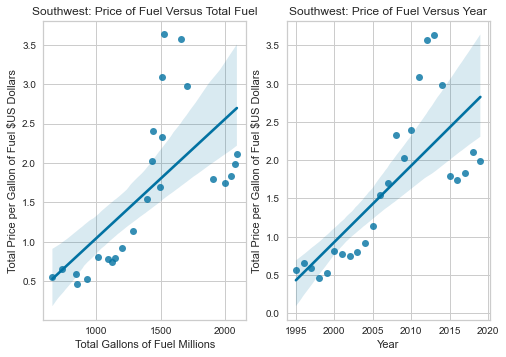

Spirit
Correlation: 0.1145723421084463


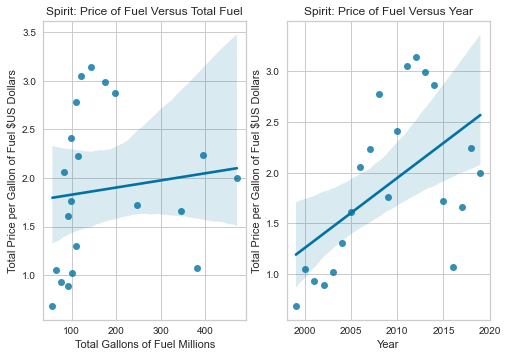

US Airways
Correlation: 0.10085034448888192


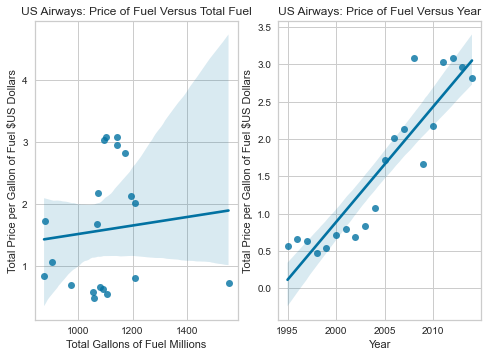

United
Correlation: -0.03282002558787108


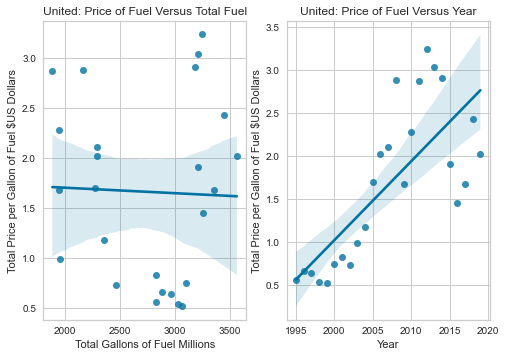

Virgin America
Correlation: -0.29128808779559795


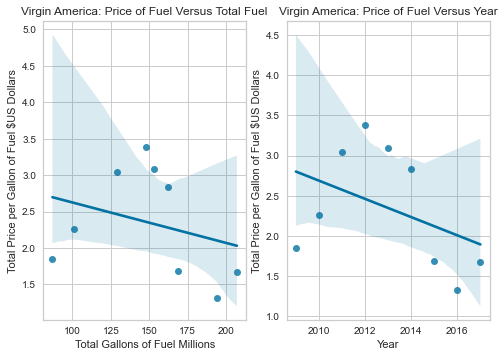

jetBlue
Correlation: 0.5604002125786961


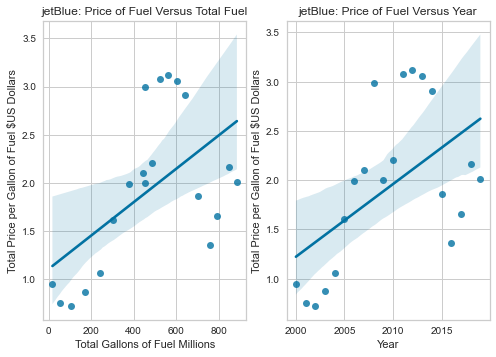

In [14]:
#@widgets.interact(airline=lstAirlines)
def showInvAirlineFuelExpensePerMGallon(airline:str, fuelpriceDF:pd.DataFrame)->None:
    """Show the individual airlines plots, as the table is probably not the whole story
    
    params
    ------
    airline:str: the airline to show the plot of
    
    fuelpriceDF:pd.DataFrame: the reduced dataframe with the data"""
    # copy & filter dataframe
    tmp = fuelpriceDF.copy()
    tmp = tmp[tmp['Airline'] == airline]

    # create subplots to take up less space
    fig, axes = plt.subplots(nrows=1, ncols=2)

    sns.regplot(data=tmp, y='Total Price per Gallon of Fuel $US Dollars', x='Total Gallons of Fuel Millions', ax=axes[0])
    axes[0].set_title(airline + ': Price of Fuel Versus Total Fuel')
    
    sns.regplot(data=tmp, y='Total Price per Gallon of Fuel $US Dollars', x='Year', ax=axes[1])
    axes[1].set_title(airline + ': Price of Fuel Versus Year')
    
    # Get the correlation as well
    print('Correlation:', tmp.corr().iloc[0,1])
    plt.show()
fuelpriceDF = getReducedDfForFuelPrice()
for airline in lstAirlines:
    print(airline)
    showInvAirlineFuelExpensePerMGallon(airline, fuelpriceDF)

From the plot with all of the airlines, fuel price per gallon and total fuel used we can see that there does not appear to be any correlation. Digging into the individual airlines we can see that some of them appear to have some correlations between the two, but with huge confidence intervals suggesting that either we are shopping for an effect that is not there or the price of fuel may be affected by where the airline operates: airTran from Orlando, Alaska the West coast, America West Arizona/Nevada, Hawaiian Hawaii (but to and from a lot of places all over the US and worldwide) and Virgin America West Coast. The remainder (Allegiant, US Airways, Continental (South, Middle and Guam), Delta, Frontier, Northwest, Southwest, Spirit, United and JetBlue effectively operate all over the USA and several across the world.

From https://www.airlines.org/wp-content/uploads/2018/01/jet-fuel-1.pdf page 4 (and the picture on page 7) we can get an overview of the market for jet fuel in the US. There are various different regions served by different pipelines (sometimes with competition) and the airlines can choose to either buy the fuel in advance from the suppliers at negotiated prices (being able to hedge their prices on the futures/options markets) or buy the fuel from the airport.

Broadly speaking the price of fuel increased year on year, but Virgin America and Alligent managed to escape that trend (though as both airline's data ends before everyone else's that indicates that they stopped trading).

In conclusion fuel price is dependent upon the airline, due to either its region or fuel hedging strategy, rather than upon the volume used (though indirectly that may have some standing upon their supply deals).

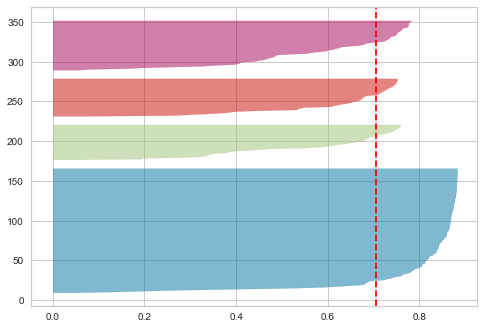

alt.Chart(...)

Cluster score: 0.7057862325423961


In [15]:
# Cluster up airlines and their prices
def airlineFuelClust(num_clusters):
    """Used to see any clusters of similar airlines in their pricing strategy
    4 clusters gives the best score"""
    tmp = getReducedDfForFuelPrice()
    
    # Using https://stackoverflow.com/questions/44721565/pandas-merge-rows-and-add-columns-with-get-dummies
    tmp = pd.concat([tmp, pd.get_dummies(tmp['Airline'])], axis=1)
    
    useCols = [i for i in tmp.columns if i != 'Airline']
    
    scr = clusterify(num_clusters, False, tmp, useCols)
    plt.show()
    
    # show the clusters
    display(alt.Chart(tmp, title='Clusters of fuel price against year').mark_circle().encode(
            alt.X('Year', scale=alt.Scale(zero=False), axis=alt.Axis(format='f')),
            alt.Y('Total Price per Gallon of Fuel $US Dollars', axis=alt.Axis(format='$', title='Total Price per Gallon of Fuel')),
            tooltip=['Airline', 'Total Price per Gallon of Fuel $US Dollars','Total Gallons of Fuel Millions', 'Year'],
            # Get Altair colour schemes from https://vega.github.io/vega/docs/schemes/
            color=alt.Color('cluster:Q', scale=alt.Scale(scheme='category20')) # from https://stackoverflow.com/questions/55379035/set-a-diverging-color-scheme-to-center-on-zero-in-altair
        )) # .interactive())
    
    print('Cluster score:', scr)
airlineFuelClust(4) # Best value and attempt to remove some of the interactivity to improve performance

### Q3 - How does profit depend upon fuel price?

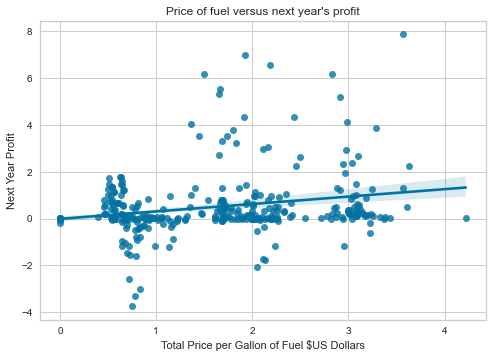

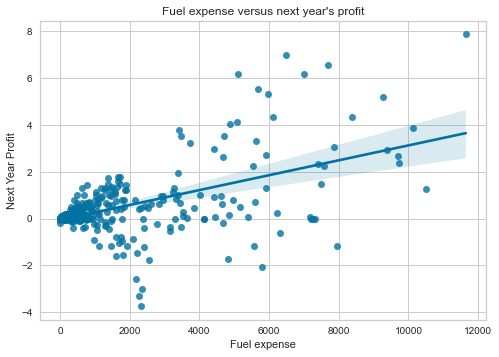

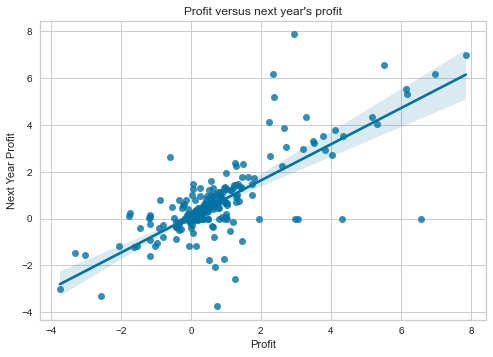

profit  \
profit                                      1.000000   
Total Price per Gallon of Fuel $US Dollars  0.194556   
fuelExpense                                 0.510325   
nextProfit                                  0.770596   

                                            Total Price per Gallon of Fuel $US Dollars  \
profit                                                                        0.194556   
Total Price per Gallon of Fuel $US Dollars                                    1.000000   
fuelExpense                                                                   0.516249   
nextProfit                                                                    0.272761   

                                            fuelExpense  nextProfit  
profit                                         0.510325    0.770596  
Total Price per Gallon of Fuel $US Dollars     0.516249    0.272761  
fuelExpense                                    1.000000    0.556463  
nextProfit                                     0.556463    1.000000

In [16]:
# Check the linearity assumption
X = df.copy()
X = X[['Total Price per Gallon of Fuel $US Dollars', 'profit', 'nextProfit','Total Gallons of Fuel Millions']]

# Fill NAs
X['Total Gallons of Fuel Millions'] = X['Total Gallons of Fuel Millions'].fillna(0)
X['Total Price per Gallon of Fuel $US Dollars'] = X['Total Price per Gallon of Fuel $US Dollars'].fillna(0)
X['profit'] = X['profit'].fillna(0)
X['nextProfit'] = X['nextProfit'].fillna(0)

# Derived feature
X['fuelExpense'] = X['Total Price per Gallon of Fuel $US Dollars'] * X['Total Gallons of Fuel Millions']

X = X[['profit', 'Total Price per Gallon of Fuel $US Dollars', 'fuelExpense', 'nextProfit']]

sns.regplot(data=X, x='Total Price per Gallon of Fuel $US Dollars', y='nextProfit')
plt.ylabel('Next Year Profit')
plt.title("Price of fuel versus next year's profit")
plt.show()

sns.regplot(data=X, x='fuelExpense', y='nextProfit')
plt.ylabel('Next Year Profit')
plt.title("Fuel expense versus next year's profit")
plt.xlabel("Fuel expense")
plt.show()

sns.regplot(data=X, x='profit', y='nextProfit')
plt.ylabel('Next Year Profit')
plt.title("Profit versus next year's profit")
plt.xlabel("Profit")
plt.show()

display(X.corr())

# remove dataframe now it isn't needed
del X 

The relationship between fuel price and the next year's profit is weak (0.2).

The interaction between fuel price and the amount of fuel used has a much stronger relationship to the next year's profit (0.5) (obviously it cannot predict the amount of demand there will be for the flights or the other expenses an airline has).

Finally, the current year's profit has a big effect on next year's profit (0.8) (something to be expected, big profit this year means that you can invest to earn more next year and conversely if you made a loss then you may have to borrow money or reduce costs).

Score: 0.5744462008151894
Score Training: 0.9597080717442437
RMSE 0.6709617493105752


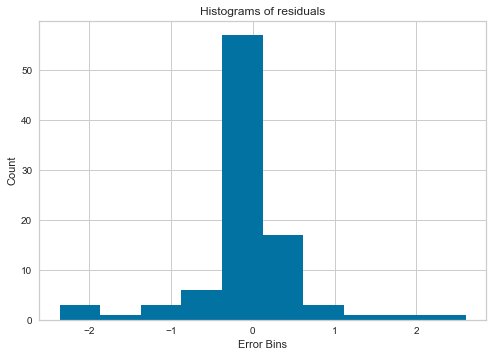

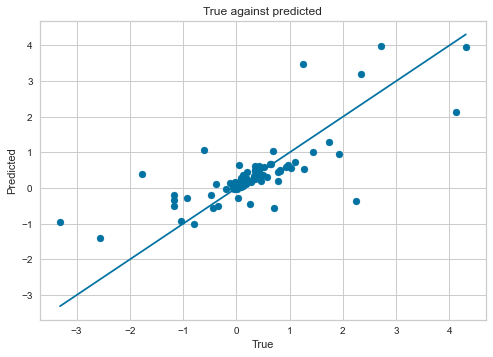

In [17]:
def getTestAndTrainingData():
    """Get the test and training data for Question 3.
    
    Returns
    Tuple with X_train, X_test, y_train, y_test"""
    # Get a copy of the data
    tmp = df.copy()
    
    # Filter out null target columns
    tmp = tmp[(tmp['profit'].isnull() == False) & (tmp['nextProfit'].isnull() == False)]

    # Get profit
    y = tmp['nextProfit']
    
    # Wipe out the unnessary columns
    tmp = tmp[[
            'Airline',
            'Year',
            'Total Gallons of Fuel Millions',
            'Total Price per Gallon of Fuel $US Dollars',
    ]]
    
    # Run get dummies to encode the airline
    # Using https://stackoverflow.com/questions/44721565/pandas-merge-rows-and-add-columns-with-get-dummies
    tmp = pd.concat([tmp, pd.get_dummies(tmp['Airline'])], axis=1)
    tmp.drop('Airline', axis=1, inplace=True)

    # Run through train test split
    X_train, X_test, y_train, y_test = train_test_split(tmp, y, test_size=0.3, random_state=42)
    return X_train, X_test, y_train, y_test

# Find best params for random forest
# Some help from https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# from sklearn.model_selection import GridSearchCV
# params = {
#    'rfr__n_estimators': [149],#[i for i in range(141,160)],#[50, 100, 150, 200],
#    'rfr__max_depth': [17],#[i for i in range(16,25)], #[None, 5, 10, 15, 20, 25, 30],
#    'rfr__min_samples_leaf': [i for i in range(1,5)], #[1, 5, 10, 15]
#}

#s = GridSearchCV(estimator=pipe, param_grid=params, scoring='r2')
#s.fit(X_train, y_train)
#print(s.best_params_)

# Make the pipeline
pipe = Pipeline([
    ('si', SimpleImputer()), # https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
    ('rfr', RandomForestRegressor(random_state=42, max_depth=17, n_estimators=149))
])
# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline

X_train, X_test, y_train, y_test = getTestAndTrainingData()

# Fit and score model
mdl = pipe.fit(X_train, y_train)
print('Score:', mdl.score(X_test, y_test))
print('Score Training:', mdl.score(X_train, y_train))

y_pred = pipe.predict(X_test)

# Plot the graphs
residual_plots(y_test, y_pred)

Score: 0.7221299792602061
Score Training: 0.9999967115404207
RMSE 0.5421773530604985


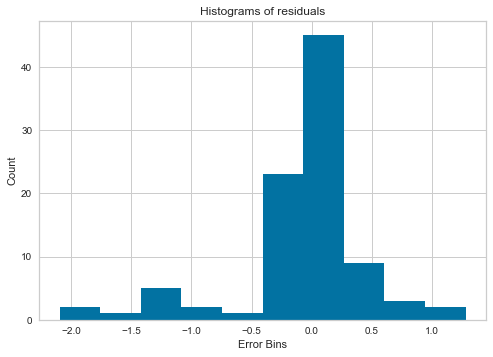

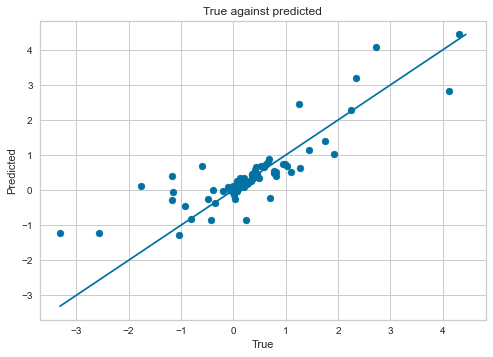

In [18]:
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

#X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
#from sklearn.model_selection import GridSearchCV
#params = {
#    'xg__n_estimators': [99], # [i for i in range(90,110)],#[50, 100, 150, 200],
#    'xg__max_depth': [None], #[None, 5, 10, 15, 20, 25, 30],
#    'xg__learning_rate': [0.019]#[i * 0.001 for i in range(10,20)], #,[0.1,0.01,0.001,0.0001,0.00001],
#}
#s = GridSearchCV(estimator=reg, param_grid=params, scoring='r2')
#s.fit(X_train2, y_train2)
#print(s.best_params_)

# Make the model outside the pipe so we can get its feature importance later
xg = xgb.XGBRegressor(
        random_state = 42,
        n_estimators = 99,
        )
# make the pipeline
reg = Pipeline([
    ('si', SimpleImputer()), # https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
    ('xg', xg)
])
# fit the pipeline
reg.fit(X_train, y_train)
print('Score:', reg.score(X_test, y_test))
print('Score Training:', reg.score(X_train, y_train))

# Make the predictions
y_pred = reg.predict(X_test)
# Run off the plot of residuals and true against prediction
residual_plots(y_test, y_pred)

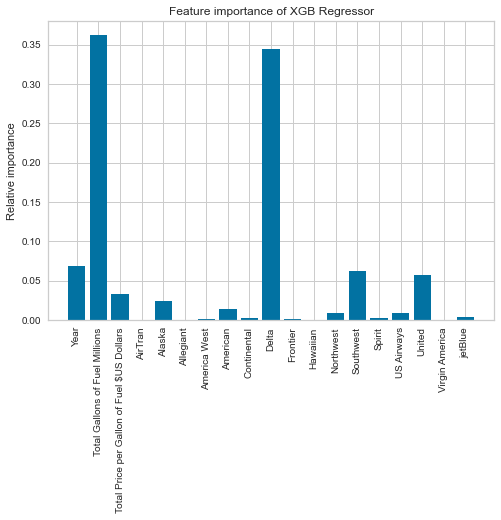

In [19]:
# Show the feature importances
# Get a number for each column in the training data
rng = [i for i in range(len(X_train.columns))]

# Get the feature importances (https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)
plt.bar(rng, xg.feature_importances_)
# using code from https://stackoverflow.com/questions/11244514/modify-tick-label-text
plt.xticks(rng, X_train.columns, rotation='vertical')
plt.ylabel("Relative importance")
plt.title("Feature importance of XGB Regressor")
plt.show()

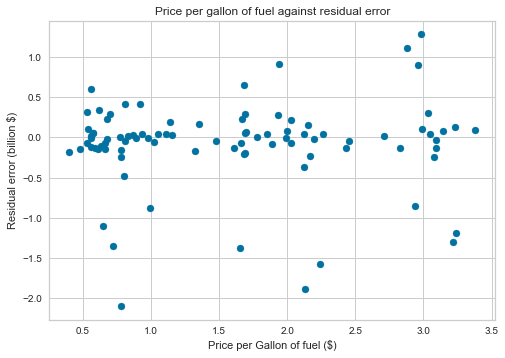

In [20]:
# Show residual plot for price of fuel
plt.scatter(X_test['Total Price per Gallon of Fuel $US Dollars'], y_test - y_pred)

# Label graph
plt.xlabel("Price per Gallon of fuel ($)")
plt.ylabel("Residual error (billion $)")
plt.title("Price per gallon of fuel against residual error")
plt.show()

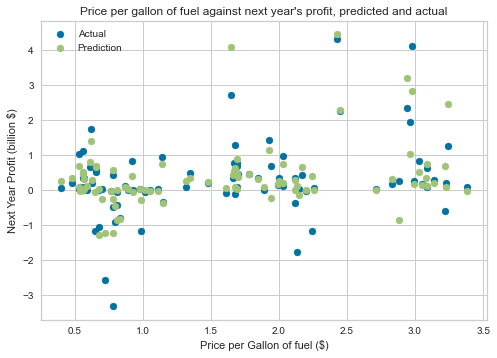

In [21]:
# Show fuel price against profit for y prediction and true

# True values
plt.scatter(X_test['Total Price per Gallon of Fuel $US Dollars'], y_test, label='Actual')
# Predicted values
plt.scatter(X_test['Total Price per Gallon of Fuel $US Dollars'], y_pred, label="Prediction")
plt.legend() # Show the legend

# Label graph
plt.xlabel("Price per Gallon of fuel ($)")
plt.ylabel("Next Year Profit (billion $)")
plt.title("Price per gallon of fuel against next year's profit, predicted and actual")
plt.show()

From the feature importance we can see that the total amount of fuel is very important, as is whether the airline is Delta airlines (which may mean that it has overfit to their profit, which may be because they are one of the more profitable and long-lasting airlines). This illustrates that we can build a relatively accurate graph with just a few features.

### Q4 - How does next year's profit depend upon labour costs?
Here we will be building an SVG model to deal with fuel price, amount of fuel, labour costs, airline and year.

In [22]:
# As we don't have data going down to the month level we don't need to do the adfuller test for whether the data is seasonal or not, as it won't be
# get the dataset, we'll use 2018 & 19 as the test set
def getTimeData(airline='', splitTestTrain=False, year = 2018):
    """This is to get the time data for each company and split into test and training sets

    params
    airline:str: airline to filter on

    splitTestTrain:bool: whether or not to split into test and training data
    year: year to split test data on
    returns:
    if splitTestTrain: X_train, X_test, y_train, y_test
    else X"""
    # Take a copy of the data frame so that the original doesn't complain about us slicing and reordering it
    td = df.copy()

    # Get the columns we want
    td = td[[
        'Airline',
        'Year',
        'Total Gallons of Fuel Millions',
        'Total Price per Gallon of Fuel $US Dollars',
        'System Total Labor and Related Expenses $ Billions',
        'System Passenger Revenue billion $',
        'Total Fuel Expense',
        'System Total Enplaned Passengers Thousands',
        'profit',
        'nextProfit',
    ]]

    # Drop na rows for profit
    td = td[td['profit'].isna() == False]
    td = td[td['nextProfit'].isna() == False]

    # Encode the airline
    # Using https://stackoverflow.com/questions/44721565/pandas-merge-rows-and-add-columns-with-get-dummies
    td = pd.concat([td, pd.get_dummies(td['Airline'])], axis=1)

    # If filtering
    if airline != '':
        td = td[td['Airline'] == airline]

    # Drop the airline column
    td.drop('Airline', axis=1, inplace=True)

    # Rename columns
    td.rename(columns={
        'Total Gallons of Fuel Millions': 'totalFuel',
        'Total Price per Gallon of Fuel $US Dollars': 'fuelPrice',
        'System Total Labor and Related Expenses $ Billions': 'labourCost',
        'America West': 'AmericaWest',
        'Virgin America': 'VirginAmerica',
        'System Passenger Revenue billion $': 'passengerRevenue',
        'Total Fuel Expense': 'fuelExpense',
        'System Total Enplaned Passengers Thousands': 'passengersThousands'
    }, inplace=True)

    # split out test & training data
    if splitTestTrain:
        # cut out 2018 data and copy so python isn't upset by the drop
        td_2018 = td[(td['Year'] >= year) & (td['Year'] < 2019)].copy()
        td_other = td[td['Year'] < year].copy()

        # split y
        y_2018 = td_2018['nextProfit']
        y_other = td_other['nextProfit']

        # drop nextProfit
        td_2018.drop('nextProfit', axis=1, inplace=True)
        td_other.drop('nextProfit', axis=1, inplace=True)

        return td_other, td_2018, y_other, y_2018

    return td
getTimeData()

Year  totalFuel  fuelPrice  labourCost  passengerRevenue  fuelExpense  \
0    1995     2749.0       0.54        5.74             13.33       1478.0   
1    1995     1061.0       0.53        1.32              4.35        567.0   
2    1995     2500.0       0.55        4.23             11.39       1365.0   
3    1995     1846.0       0.56        3.03              7.76       1027.0   
4    1995     2822.0       0.56        5.29             13.03       1579.0   
..    ...        ...        ...         ...               ...          ...   
378  2018      247.0       2.26        0.50              1.20        558.0   
380  2018      676.0       2.35        2.14              6.04       1587.0   
381  2018      271.0       2.12        0.72              2.43        576.0   
382  2018      396.0       2.24        0.72              1.89        888.0   
383  2018      191.0       2.33        0.44              1.04        446.0   

     passengersThousands  profit  nextProfit  AirTran  ...  Delta  Frontier  \
0                79567.0    0.97        1.33        0  ...      0         0   
1                35284.0    0.24        0.40        0  ...      0         0   
2                86963.0    1.04        0.57        0  ...      1         0   
3                49370.0    0.91        1.11        0  ...      0         0   
4                78808.0    0.83        1.13        0  ...      0         0   
..                   ...     ...         ...      ...  ...    ...       ...   
378              19433.0    0.12        0.31        0  ...      0         1   
380              35601.0    0.69        1.03        0  ...      0         0   
381              11630.0    0.33        0.34        0  ...      0         0   
382              28683.0    0.35        0.50        0  ...      0         0   
383              13847.0    0.22        0.34        0  ...      0         0   

     Hawaiian  Northwest  Southwest  Spirit  US Airways  United  \
0           0          0          0       0           0       0   
1           0          0          0       0           0       0   
2           0          0          0       0           0       0   
3           0          1          0       0           0       0   
4           0          0          0       0           0       1   
..        ...        ...        ...     ...         ...     ...   
378         0          0          0       0           0       0   
380         0          0          0       0           0       0   
381         1          0          0       0           0       0   
382         0          0          0       1           0       0   
383         0          0          0       0           0       0   

     VirginAmerica  jetBlue  
0                0        0  
1                0        0  
2                0        0  
3                0        0  
4                0        0  
..             ...      ...  
378              0        0  
380              0        0  
381              0        0  
382              0        0  
383              0        0  

[309 rows x 25 columns]

0.2936714433457158 True AirTran
0.8518380930712206 True Alaska
1.0 True Allegiant
0.25928597257499597 True America West
0.5266338594062961 True American
0.08593479608893423 True Continental
0.7984007940666148 True Delta
0.668232035958754 True Frontier
0.8189666014659251 True Hawaiian
0.032898139932768716 False Northwest
0.8368900795109768 True Southwest
0.7837740954793486 True Spirit
0.312735468563488 True US Airways
0.6374941005990652 True United
0.15826879902254598 True Virgin America
0.993072921766683 True jetBlue


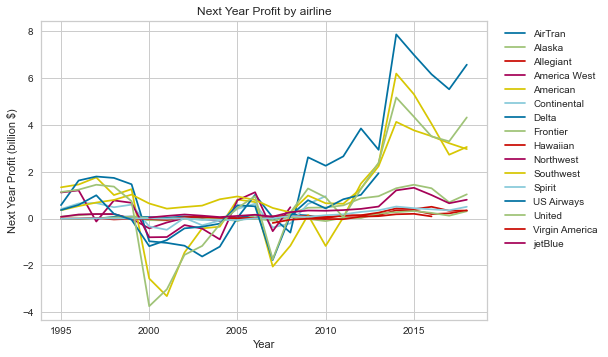

In [23]:
# Run adfuller test to see if the data is stationary (seasonal) or not
# Plot the airline's profits
for airline in lstAirlines:
    # get the data
    td = getTimeData(airline=airline)

    # run the adfuller test
    # code adapted from https://www.analyticsvidhya.com/blog/2020/10/how-to-create-an-arima-model-for-time-series-forecasting-in-python/
    res = adfuller(td['nextProfit'])
    print(res[1], res[1] > 0.05, airline)

    # Plot the profit for the airline
    plt.plot(td['Year'], td['nextProfit'], label=airline)
plt.legend(bbox_to_anchor=(1.02, 1), loc=2) # from https://www.geeksforgeeks.org/how-to-place-legend-outside-the-plot-with-seaborn-in-python/
plt.title("Next Year Profit by airline")
plt.xlabel('Year')
plt.ylabel('Next Year Profit (billion $)')
plt.show()

In [24]:
getTimeData(airline='Northwest')

Year  totalFuel  fuelPrice  labourCost  passengerRevenue  fuelExpense  \
3    1995     1846.0       0.56        3.03              7.76       1027.0   
19   1996     1945.0       0.67        3.10              8.60       1307.0   
35   1997     1996.0       0.65        3.15              8.72       1295.0   
51   1998     1877.0       0.54        3.39              7.51       1006.0   
67   1999     2040.0       0.54        3.55              8.59       1094.0   
83   2000     2113.0       0.83        3.77              9.52       1758.0   
99   2001     2029.0       0.79        4.09              8.22       1612.0   
115  2002     1896.0       0.70        3.96              7.75       1318.0   
131  2003     1752.0       0.81        3.96              7.62       1417.0   
147  2004     1766.0       1.18        3.91              8.43       2086.0   
163  2005     1744.0       1.69        3.85              8.84       2954.0   
179  2006     1593.0       2.03        2.79              9.05       3226.0   
195  2007     1545.0       2.05        2.63              9.29       3173.0   
211  2008     1427.0       3.61        2.70              9.39       5146.0   

     passengersThousands  profit  nextProfit  AirTran  ...  Delta  Frontier  \
3                49370.0    0.91        1.11        0  ...      0         0   
19               52722.0    1.11        1.20        0  ...      0         0   
35               54704.0    1.20       -0.13        0  ...      0         0   
51               50539.0   -0.13        0.77        0  ...      0         0   
67               54764.0    0.77        0.67        0  ...      0         0   
83               56927.0    0.67       -0.80        0  ...      0         0   
99               52374.0   -0.80       -0.79        0  ...      0         0   
115              51827.0   -0.79       -0.28        0  ...      0         0   
131              51976.0   -0.28       -0.43        0  ...      0         0   
147              55446.0   -0.43       -0.89        0  ...      0         0   
163              56537.0   -0.89        0.78        0  ...      0         0   
179              54888.0    0.78        1.12        0  ...      0         0   
195              53737.0    1.12       -0.54        0  ...      0         0   
211              48921.0   -0.54        0.48        0  ...      0         0   

     Hawaiian  Northwest  Southwest  Spirit  US Airways  United  \
3           0          1          0       0           0       0   
19          0          1          0       0           0       0   
35          0          1          0       0           0       0   
51          0          1          0       0           0       0   
67          0          1          0       0           0       0   
83          0          1          0       0           0       0   
99          0          1          0       0           0       0   
115         0          1          0       0           0       0   
131         0          1          0       0           0       0   
147         0          1          0       0           0       0   
163         0          1          0       0           0       0   
179         0          1          0       0           0       0   
195         0          1          0       0           0       0   
211         0          1          0       0           0       0   

     VirginAmerica  jetBlue  
3                0        0  
19               0        0  
35               0        0  
51               0        0  
67               0        0  
83               0        0  
99               0        0  
115              0        0  
131              0        0  
147              0        0  
163              0        0  
179              0        0  
195              0        0  
211              0        0  

[14 rows x 25 columns]

All p-values are greater than 0.05 so the data isn't stationary. Apart from North West airline's next year's profit which is stationary around $0 billion profit, with up to a billion or so either way in variation. For now, we are going to continue and keep an eye on their numbers.

Score: 0.9069705989774868
RMSE 0.6187062140688724


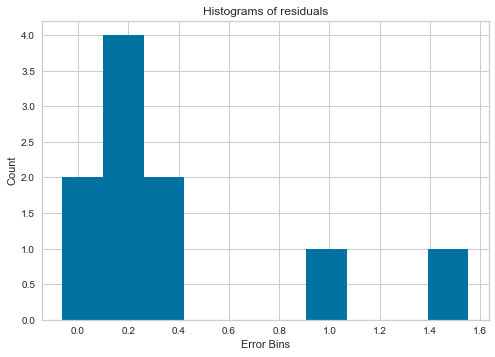

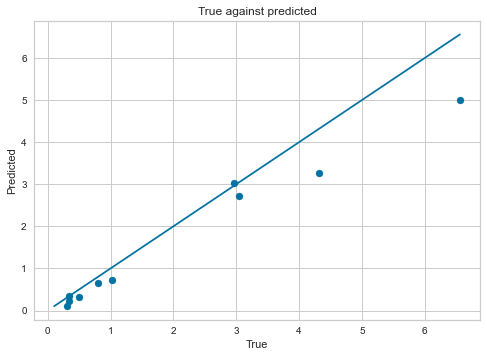

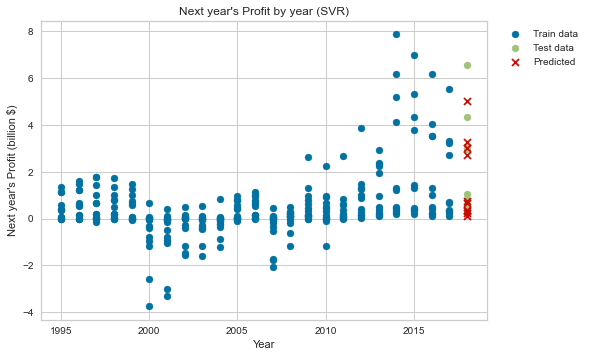

In [25]:
# using https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
# make the pipeline
# Hyperparameter tuning is in NotebookHelp/gridsearchSVR. However it got worse than the default parameters
pipeSVR = Pipeline([
    ('si', SimpleImputer()),
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='linear'))
])

# get the data
t_train, t_test, p_train, p_test = getTimeData(splitTestTrain=True)

# fit the pipe
pipeSVR.fit(t_train, p_train)

# score
print('Score:', pipeSVR.score(t_test, p_test))

# make predictions
p_preds = pipeSVR.predict(t_test)

# Residual plots
residual_plots(p_test, p_preds)

# Plot the train, test and pred data
plt.scatter(t_train['Year'], p_train, label='Train data')

plt.scatter(t_test['Year'], p_test, label='Test data')

plt.scatter(t_test['Year'], p_preds, marker='x', label='Predicted')

plt.xlabel("Year")
plt.ylabel("Next year's Profit (billion $)")
plt.title("Next year's Profit by year (SVR)")

plt.legend(bbox_to_anchor=(1.02, 1), loc=2) # code line from https://www.geeksforgeeks.org/how-to-place-legend-outside-the-plot-with-seaborn-in-python/
plt.show()

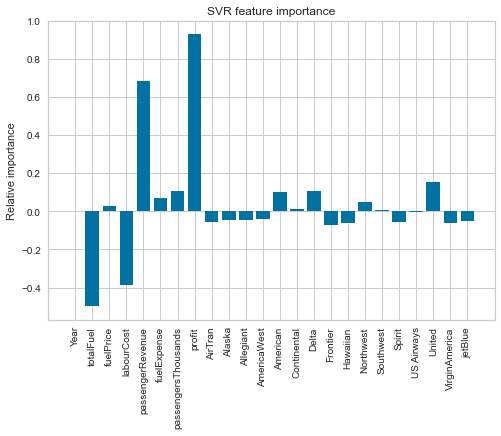

In [26]:
# Feature importance
rng = [i for i in range(len(t_train.columns))]
plt.bar(rng, pipeSVR[2].coef_[0])
plt.xticks(rng, t_train.columns, rotation='vertical') # using code from https://stackoverflow.com/questions/11244514/modify-tick-label-text
plt.ylabel("Relative importance")
plt.title("SVR feature importance")
plt.show()

Score: 0.8790288695850227
RMSE 0.705529593590197


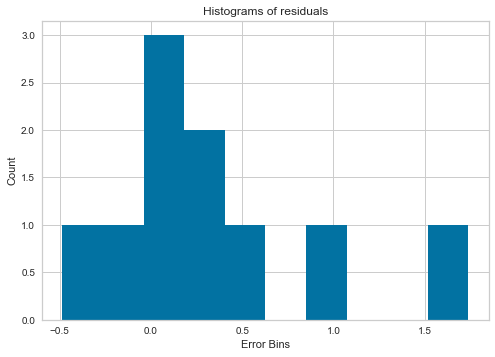

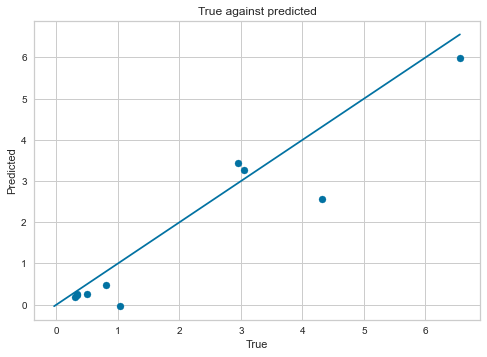

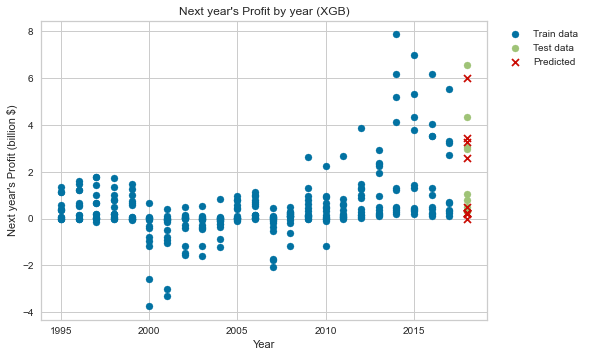

In [27]:
# Check the performance of the SVR model by comparing it to the XGB Regressor
pipeXGBQ4 = Pipeline([
    ('si', SimpleImputer()),
    ('scaler', StandardScaler()),
    ('xg', xgb.XGBRegressor(random_state = 42))
])

# get the data
t_train, t_test, p_train, p_test = getTimeData(splitTestTrain=True)

# fit the pipe
pipeXGBQ4.fit(t_train, p_train)

# score
print('Score:', pipeXGBQ4.score(t_test, p_test))

# make predictions
p_preds = pipeXGBQ4.predict(t_test)

# Residual plots
residual_plots(p_test, p_preds)

# Plot the train, test and pred data
plt.scatter(t_train['Year'], p_train, label='Train data')

plt.scatter(t_test['Year'], p_test, label='Test data')

plt.scatter(t_test['Year'], p_preds, marker='x', label='Predicted')

plt.xlabel("Year")
plt.ylabel("Next year's Profit (billion $)")
plt.title("Next year's Profit by year (XGB)")

plt.legend(bbox_to_anchor=(1.02, 1), loc=2) # code line from https://www.geeksforgeeks.org/how-to-place-legend-outside-the-plot-with-seaborn-in-python/
plt.show()

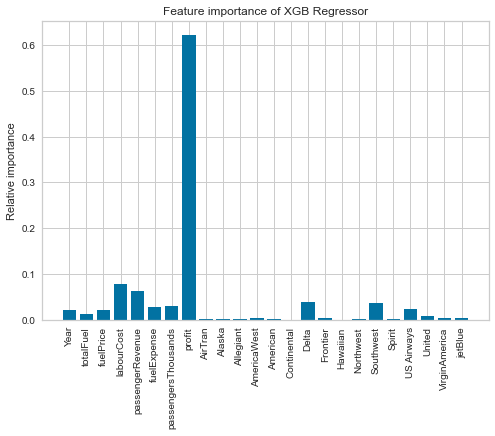

In [28]:
# Show the feature importances
# Get a number for each column in the training data
rng = [i for i in range(len(t_train.columns))]

# Get the feature importances (https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)
plt.bar(rng, pipeXGBQ4[2].feature_importances_)
# using code from https://stackoverflow.com/questions/11244514/modify-tick-label-text
plt.xticks(rng, t_train.columns, rotation='vertical')
plt.ylabel("Relative importance")
plt.title("Feature importance of XGB Regressor")
plt.show()

We can see that we can use Support Vector Regression to predict the profits of at least the lower profit airlines with reasonable accuracy. Delta and United airlines' profit were the least accurate. However these two had the highest profit, so were the most different from the rest. As we have very little training data our numbers are not going to be much more than a reasonable guess.

We can however see that the SVR model is a slightly better fit than the XGB Regression model (0.907 versus 0.879 score and 0.619 versus 0.706 (billion $) RMSE). From the feature importance we can see that SVR looks at total fuel, labour, passenger revenue and profit, whereas XGB just looks at the profit.

### Q5 - What could happen to airlines in the future?

Year  totalFuel  fuelPrice  labourCost  passengerRevenue  fuelExpense  \
1    2020     3632.0        2.0       13.41             32.85       7264.0   
11   2021     3632.0        2.0       13.41             32.85       7264.0   
21   2022     3632.0        2.0       13.41             32.85       7264.0   
31   2023     3632.0        2.0       13.41             32.85       7264.0   
41   2024     3632.0        2.0       13.41             32.85       7264.0   
51   2025     3632.0        2.0       13.41             32.85       7264.0   
61   2026     3632.0        2.0       13.41             32.85       7264.0   
71   2027     3632.0        2.0       13.41             32.85       7264.0   
81   2028     3632.0        2.0       13.41             32.85       7264.0   
91   2029     3632.0        2.0       13.41             32.85       7264.0   
101  2030     3632.0        2.0       13.41             32.85       7264.0   

     passengersThousands    profit  AirTran  Alaska  ...  Frontier  Hawaiian  \
1               162777.0  6.560000        0       0  ...         0         0   
11              162777.0  5.712124        0       0  ...         0         0   
21              162777.0  5.095477        0       0  ...         0         0   
31              162777.0  4.647119        0       0  ...         0         0   
41              162777.0  4.321240        0       0  ...         0         0   
51              162777.0  4.084501        0       0  ...         0         0   
61              162777.0  3.912637        0       0  ...         0         0   
71              162777.0  3.787991        0       0  ...         0         0   
81              162777.0  3.697708        0       0  ...         0         0   
91              162777.0  3.632435        0       0  ...         0         0   
101             162777.0  3.585364        0       0  ...         0         0   

     Northwest  Southwest  Spirit  US Airways  United  VirginAmerica  jetBlue  \
1            0          0       0           0       0              0        0   
11           0          0       0           0       0              0        0   
21           0          0       0           0       0              0        0   
31           0          0       0           0       0              0        0   
41           0          0       0           0       0              0        0   
51           0          0       0           0       0              0        0   
61           0          0       0           0       0              0        0   
71           0          0       0           0       0              0        0   
81           0          0       0           0       0              0        0   
91           0          0       0           0       0              0        0   
101          0          0       0           0       0              0        0   

     nextProfit  
1      5.712124  
11     5.095477  
21     4.647119  
31     4.321240  
41     4.084501  
51     3.912637  
61     3.787991  
71     3.697708  
81     3.632435  
91     3.585364  
101    3.551541  

[11 rows x 25 columns]

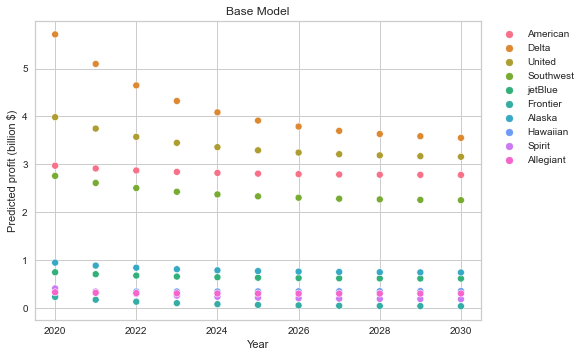

In [29]:
def feedForwardModel(df:pd.DataFrame, title:str, adjustments:dict, revPerPassengerAdjust=1.0, num_years=11)->pd.DataFrame:
    """Here we filter to the 2019 data, then use it to predict 2020's data.
    Then use that to predict 2021, etc."""
    # filter to the 2019 data
    base_2019 = df[df['Year'] == 2019].copy()

    # Get the columns we want
    base_2019 = base_2019[[
        'Airline',
        'Year',
        'Total Gallons of Fuel Millions',
        'Total Price per Gallon of Fuel $US Dollars',
        'System Total Labor and Related Expenses $ Billions',
        'System Passenger Revenue billion $',
        'Total Fuel Expense',
        'System Total Enplaned Passengers Thousands',
        'profit',
        'nextProfit',
    ]]

    # Drop na rows for profit
    base_2019 = base_2019[base_2019['profit'].isna() == False]

    # Encode the airline
    # Using https://stackoverflow.com/questions/44721565/pandas-merge-rows-and-add-columns-with-get-dummies
    base_2019 = pd.concat([base_2019, pd.get_dummies(base_2019['Airline'])], axis=1)

    # Drop the airline column
    base_2019.drop('Airline', axis=1, inplace=True)

    # Drop the nextProfit column
    base_2019.drop('nextProfit', axis=1, inplace=True)

    # Rename columns
    base_2019.rename(columns={
        'Total Gallons of Fuel Millions': 'totalFuel',
        'Total Price per Gallon of Fuel $US Dollars': 'fuelPrice',
        'System Total Labor and Related Expenses $ Billions': 'labourCost',
        'America West': 'AmericaWest',
        'Virgin America': 'VirginAmerica',
        'System Passenger Revenue billion $': 'passengerRevenue',
        'Total Fuel Expense': 'fuelExpense',
        'System Total Enplaned Passengers Thousands': 'passengersThousands'
    }, inplace=True)

    # Reset the index
    base_2019.reset_index(drop=True, inplace=True)

    # Start the prediction loop
    last_profit = None
    ret_y = None
    ret_X = None
    for i in range(num_years):
        X = base_2019.copy()
        # Update the X vectors profit
        if last_profit is not None:
            X['profit'] = last_profit
        
        # Update the x values
        X['Year'] = X['Year'] + i

        # revenue per passenger
        revenuePerPassenger = X['passengerRevenue'] / X['passengersThousands']
        revenuePerPassenger = revenuePerPassenger * np.power(revPerPassengerAdjust, i)

        # Apply the adjustments
        for k in adjustments.keys():
            X[k] = X[k] * np.power(adjustments[k], i)
        
        # update fuel expense
        X['fuelExpense'] = X['totalFuel'] * X['fuelPrice']

        # Update passengerRevenue
        X['passengerRevenue'] = revenuePerPassenger * X['passengersThousands']

        # Run the predictions
        last_profit = pipeSVR.predict(X)

        # Update the year as we're predicting next years profit
        X['Year'] = X['Year'] + 1

        # Append to return values
        if ret_y is None:
            ret_y = pd.Series(last_profit.copy())
            ret_X = X.copy()
        else:
            ret_y = ret_y.append(pd.Series(last_profit))
            ret_X = ret_X.append(X)
    ret_X['nextProfit'] = ret_y

    # plot the results
    sns.scatterplot(data=ret_X, x='Year', y='nextProfit', hue=get_airline_from_dummies(ret_X))
    plt.legend(bbox_to_anchor=(1.02, 1), loc=2) # from https://www.geeksforgeeks.org/how-to-place-legend-outside-the-plot-with-seaborn-in-python/
    plt.ylabel('Predicted profit (billion $)')
    plt.title(title)
    plt.plot()

    # Reset the index
    ret_X.reset_index(drop=True, inplace=True)
    return ret_X
d = feedForwardModel(df, 'Base Model',{})
d[d['Delta'] == 1]

From our Markov chain SVR regression model (code is all original, we saw the idea of using gaussian regression in a Markov chain on https://towardsdatascience.com/how-to-build-a-poisson-hidden-markov-model-using-python-and-statsmodels-f7aa3f46f847 but could not make sense of their code (no familiarity with statsmodels' API)). We can see that if we keep everything the same the airlines' predicted profits will fall. Curiously thanks to the COVID 19 restrictions the airline's profits did fall in 2020-21 (after that time who knows what will happen).

![HMM SVG over 110 years](img/HMMSVG110Years.png)

One problem that we can see with this form of Markov Regression (both mine and TowardsDataScience's) is that any error in the prediction is only going to get worse and magnify over time (though the graph above from running the model for 110 years shows that it initially converges down to a number and then starts a steady rise back upwards).

#### Higher priced planes that are more efficient in terms of fuel
Here we look at a potential future where fuel use drops over time.

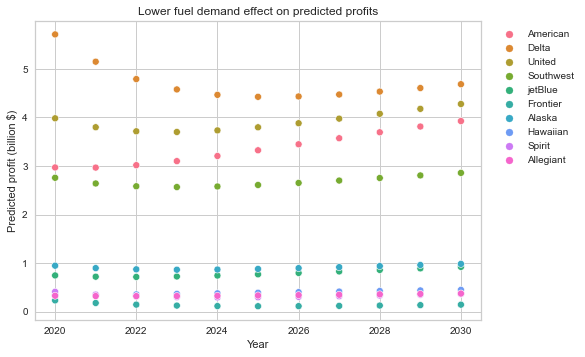

In [30]:
# Here we look at what happens if fuel use drops over time
_ = feedForwardModel(df, 'Lower fuel demand effect on predicted profits',{
    'totalFuel': 0.95,
    'labourCost': 1.01
})

We can see that our fictional more fuel-efficient new plane causes profits to climb for Delta, United, American and Southwest airlines (after the first few years which is likely the model having some noise). With a small increase for the other airlines. The Boeing 737 Max plane was introduced in 2020 with claims of increased efficiency, but was grounded first due to safety concerns (two crashes blamed on software/hardware error) and then due to the global COVID 19 pandemic (at time of writing said pandemic is ongoing).

#### Higher priced more efficient planes with a reduced labour cost

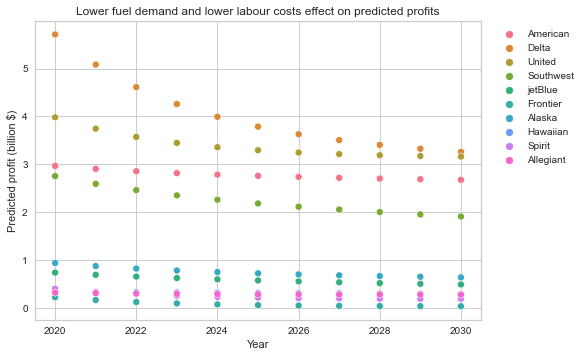

In [31]:
# Here we are going to take the 2019 data and then start dropping the fuel use for each airline by 5% per year
# for 10 years.
# We are also going to lower the labourCost by 5% to represent the additional maintenance cost
# This is to simulate a new class of high efficiency electric airplanes being introduced over time and more 
# automation (computer systems, robots, etc.)
# But also a slight fall in demand due to less need for people to go on business trips due to the same 
# automation (whether this would be countered with more tourists is debatable)
    
_ = feedForwardModel(df, 'Lower fuel demand and lower labour costs effect on predicted profits',{
    'totalFuel': 0.95,
    'labourCost': 0.95,
    'passengersThousands': 0.95,
})

We can see that our fancy fictional new planes and automation of the airlines' operations, along with the hit to customer demand really hits the bigger carriers the hardest (although American Airlines seems largely unaffected). The smaller airlines are all roughly impacted the same, though the bottom three spread out a bit more. 

#### Increased fuel costs due to higher taxes

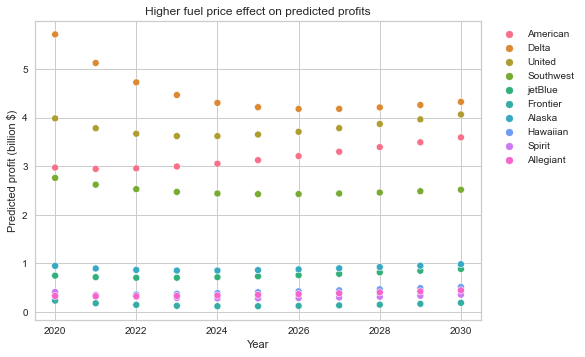

In [32]:
# Here we are going to take the 2019 data and start increasing the fuel price by 5% per year, on the grounds that either environmental taxes will be introduced 
# or the US airport fuel supply will collapse (which according to https://www.airlines.org/wp-content/uploads/2018/01/jet-fuel-1.pdf might be closer than you would think)
_ = feedForwardModel(df, 'Higher fuel price effect on predicted profits',{
    'fuelPrice': 1.05,
    'passengersThousands': 0.95,
    'totalFuel': 0.97,
}, revPerPassengerAdjust=1.05)

This scenario looks rather interesting, with a shift upwards in fuel price, which gets directly passed onto the customers. This in turn leads to a drop in demand by passengers and a drop in the amount of fuel being purchased due to either less weight on board and not needing to fly as many planes.

Initially this leads to a general drop in profit before all the airlines start to recover, with American Airlines really increasing their profits.
##### Testing SVR-M chain model

Score: 0.9575653772751862
RMSE 0.36194902301983484


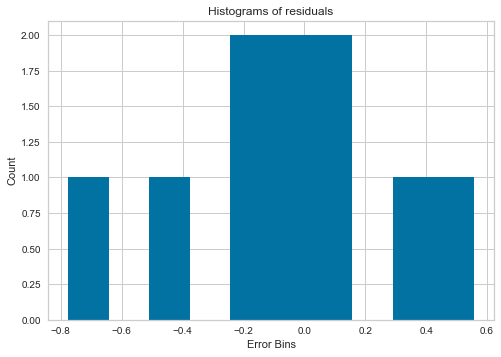

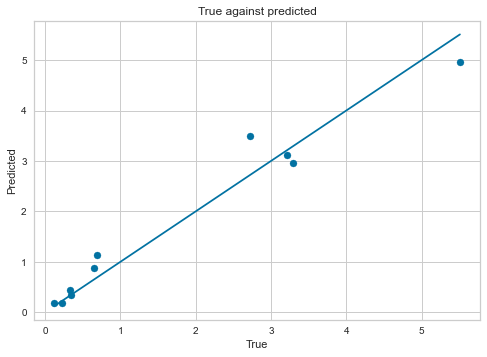

Score: 0.7750886628550369
RMSE 0.9620110030992858


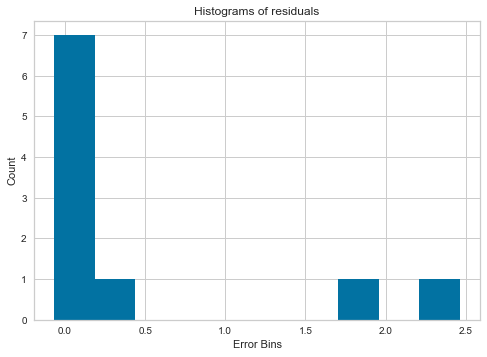

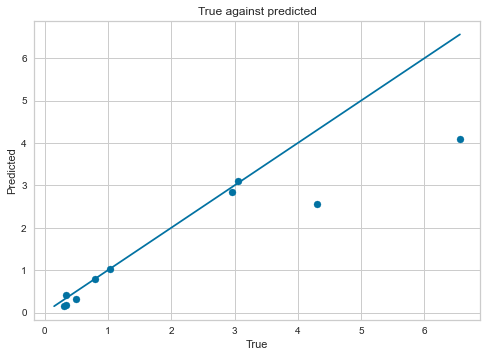

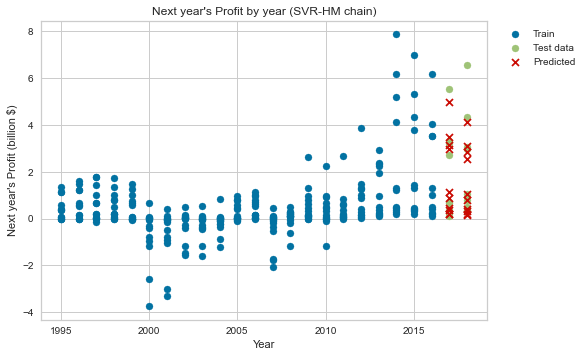

In [33]:
# test the SVR-HM chain model to see if it can predict 2018-2019's data ok
def test_svr_hmchain_model(df:pd.DataFrame)->None:
    """Test that the SVR HM chain model is of any use"""
    # get the training & test data
    X_train, X_test, y_train, y_test = getTimeData(airline='', splitTestTrain=True, year = 2017)

    # make the pipeline
    mdl = Pipeline([
        ('si', SimpleImputer()),
        ('scal', StandardScaler()),
        ('svr', SVR(kernel='linear'))
    ])

    # fit the data
    mdl.fit(X_train, y_train)

    # go into the HM chain
    last_profit = None
    ret_y = None
    ret_X = None
    for i in range(2):
        # get the relevant x data
        idx = X_test['Year'] == 2017 + i
        X = X_test[X_test['Year'] == 2017].copy()

        # Update X's profit
        if last_profit is not None:
            X['profit'] = last_profit
        
        # update year
        X['Year'] = X['Year'] + i
        
        # run the prediction
        last_profit = mdl.predict(X)

        # score
        print('Score:', mdl.score(X, y_test[idx]))

        # Analyse regression
        residual_plots(y_test[idx],last_profit)

        # Append to return values
        if ret_y is None:
            ret_y = pd.Series(last_profit.copy())
            ret_X = X.copy()
        else:
            ret_y = ret_y.append(pd.Series(last_profit))
            ret_X = ret_X.append(X)
    # Reset the index
    ret_X.reset_index(drop=True, inplace=True)
    ret_y.reset_index(drop=True, inplace=True)
    # join to make graphs easier
    ret_X['nextProfit'] = ret_y

    # Plot train, test and predicted data
    plt.scatter(X_train['Year'], y_train, label='Train')
    plt.scatter(ret_X['Year'], y_test, label='Test data')
    plt.scatter(ret_X['Year'], ret_X['nextProfit'], marker='x', label='Predicted')

    plt.xlabel("Year")
    plt.ylabel("Next year's Profit (billion $)")
    plt.title("Next year's Profit by year (SVR-HM chain)")
    plt.legend(bbox_to_anchor=(1.02, 1), loc=2) # code line from https://www.geeksforgeeks.org/how-to-place-legend-outside-the-plot-with-seaborn-in-python/
    plt.show()

test_svr_hmchain_model(df)

#### Q6 - What can we tell from passenger numbers?

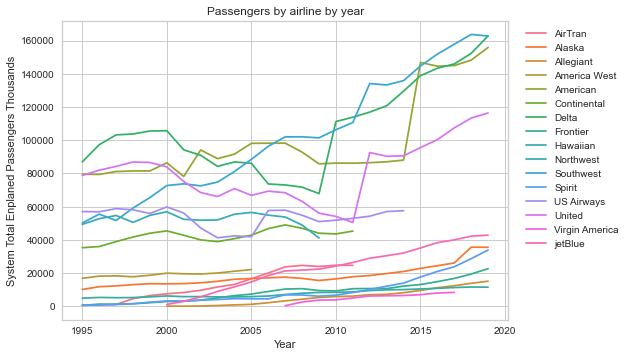

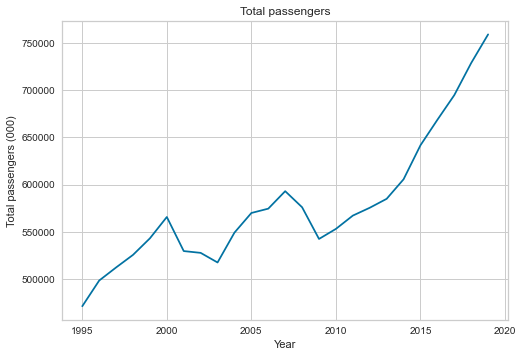

In [34]:
# Passenger numbers
sns.lineplot(data=df, x='Year', y='System Total Enplaned Passengers Thousands', hue='Airline')
plt.legend(bbox_to_anchor=(1.02, 1), loc=2) # from https://www.geeksforgeeks.org/how-to-place-legend-outside-the-plot-with-seaborn-in-python/
plt.title('Passengers by airline by year')
plt.show()
sumPass = df[['Year', 'System Total Enplaned Passengers Thousands']].copy()
sumPass = sumPass.groupby('Year').sum()
plt.plot(sumPass.index, sumPass['System Total Enplaned Passengers Thousands'])
plt.xlabel('Year')
plt.ylabel('Total passengers (000)')
plt.title('Total passengers')
plt.show()

We can see from the above graphs that the number of passengers is generally increasing year on year. These have however been more concentrated into fewer airlines at the top of the market (if we take 40 million passengers as the boundary). We can see that our timeline started with 6 main players and is down to five at the end (with Continental Airlines and jetBlue both getting into this category but with Continental merging with United ([wikipedia](https://en.wikipedia.org/wiki/Continental_Airlines#Merger_with_United_Airlines))). You can at least tell who benefitted from the 'death' of one of the airlines and be reasonably sure who did the takeover by the jump in one carrier's passenger numbers the next year.

At the bottom of the market, we can see a lot more competition with a few new companies appearing (at the top end the new entrants were smaller companies becoming big rather than an entire new company). Several of the smaller airlines vanish in mergers as well over this period, whether with other smaller airlines or one of the big airlines taking them over.

In [35]:
# Passengers by aircraft type
passengersByAircraftTypeDF = df[[
    'Airline',
    'Small Narrowbody Operating Fleet (Seat Size 150 and Less,  Single Aisle,  Multi Class Configuration)',
    'Large Narrowbody Operating Fleet (Seat Size 150+, Single Aisle)',
    'Total Widebody Operating Fleet (Dual Aisle)',
    'System Total Enplaned Passengers Thousands',
]].copy()
# Group by airline and take the average
passengersByAircraftTypeDF = passengersByAircraftTypeDF.groupby('Airline').mean()

# Rename columns to be easier to work with
passengersByAircraftTypeDF.rename(columns={
    'Small Narrowbody Operating Fleet (Seat Size 150 and Less,  Single Aisle,  Multi Class Configuration)': 'smallNarrow',
    'Large Narrowbody Operating Fleet (Seat Size 150+, Single Aisle)': 'largeNarrow',
    'Total Widebody Operating Fleet (Dual Aisle)': 'wideBody',
    'System Total Enplaned Passengers Thousands': 'numPassengers',
},inplace=True)

# fill NAs
for col in ['largeNarrow', 'wideBody', 'numPassengers']:
    passengersByAircraftTypeDF[col] = passengersByAircraftTypeDF[col].fillna(0)

display(passengersByAircraftTypeDF)
display(passengersByAircraftTypeDF.sum())

smallNarrow  largeNarrow    wideBody  numPassengers
Airline                                                            
AirTran           73.250000     0.000000    0.000000   13089.529412
Alaska            67.000000    69.631579    0.000000   18222.280000
Allegiant         34.368421    18.888889    0.000000    5727.300000
America West      73.583333    43.538462    0.000000   19287.454545
American         305.708333   271.200000  141.520000   99581.800000
Continental      187.312500   115.411765   38.117647   42485.588235
Delta            265.333333   220.080000  136.520000  106655.440000
Frontier          28.416667    26.833333    0.000000    8605.800000
Hawaiian          14.875000     9.000000   18.720000    7733.800000
Northwest        205.357143   122.400000   71.733333   52389.933333
Southwest        443.125000   116.625000    0.000000  101918.360000
Spirit            24.833333    28.375000    0.000000    9221.880000
US Airways       228.000000   101.100000   18.950000   53524.650000
United           169.208333   262.160000  145.120000   80714.640000
Virgin America     8.500000    31.818182    0.000000    5278.636364
jetBlue           48.571429   109.300000    0.000000   23494.800000

smallNarrow        2177.442826
largeNarrow        1546.362209
wideBody            570.680980
numPassengers    647931.891889
dtype: float64